Alberto Allegri

# Italian tweets analysis about Sanremo, the most important Festival in Italy

Goal of this project is to analyze the behaviour of Italian people from 7 different regions (Veneto, Lombardia, Lazio, Sicilia, Emilia-Romagna, Piemonte, Sicilia), in order to understand their attitude, their cheering and their main topics when they post a tweet containing "#sanremo". We took 7 regions that are really different in behaviours: 3 from the south, 3 from the north and one from middle-Italy.

I'll try to understand how Italian people deal with probably the most important TV show in italian history.

## 1. Data and Preprocessing 

In [1]:
'Let s import the packages that we will use during the analysis'

import re
import nltk
import time 
import spacy
import string
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sb
import multiprocessing
from matplotlib import colors
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nlp = spacy.load('it_core_news_sm')
from gensim.corpora import Dictionary
from mpl_toolkits.mplot3d import Axes3D
from gensim.models.phrases import Phrases
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA, TruncatedSVD
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.test.utils import datapath, temporary_file
from sklearn.cluster import KMeans, AgglomerativeClustering
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Phrases, Word2Vec, Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel, AuthorTopicModel

The dataset where I worked on is a dataset that I built with twitter API. I collected 6669 tweets related to Sanremo 
(most important festival in Italy) from 7 different regions (Lombardia, Lazio, Veneto, Piemonte, Sicilia, Emilia-Romagna and
Puglia) for the entire duration of the festival (since:2021-03-01 until:2021-03-07). In the dataset, there are informations 
about the Region of the writer, but also his/her id, names, hastags used, users tagged... Moreover, I personally
added two rows: one to save the original text of tweets before refining and one with the translation of tweets.

In [112]:
'''
The code I used to build my dataset
'''

#con=sqlite3.connect("example.db")
#cur=con.cursor()
#
#cur.execute("CREATE TABLE IF NOT EXISTS Sanremo(Region, id,date,retweet,favorite,brand,description,user_mentioned, hashtags,links,tweet)")
#con.commit()
#
#latlong = ['41.890631,12.4944853,80km'] #Lazio
#latlong = ['45.4642,9.1900,80km'] # Lombardia
#latlong = ['45.3456,11.4223,80km'] # Veneto
#latlong = ['44.2824,11.1709,80km'] # Emilia-Romagna
#latlong = ['44.5345,7.3405,80km'] # Piemonte
#latlong = ['40.5810,16.4018,100km'] # Puglia
#latlong = ['37.3400,14.0619,150km'] #Sicilia
#
#for hndl in latlong:
#    for status in tweepy.Cursor(api.search, q=f'#sanremo since:2021-03-01 until:2021-03-07 geocode:{hndl} -filter:retweets', tweet_mode='extended').items(5000):
#        regione = 'Sicilia'
#        tw_id=status.id
#        date=status.created_at
#        retweet=status.retweet_count
#        favorite=status.favorite_count
#        description=status.user.description.replace("\n", " ").replace("\r", " ").replace("\r\n", " ")
#        brand=status.user.screen_name
#        tweet=status.full_text.replace("\n", " ").replace("\r", " ").replace("\r\n", " ")
#        hashtags=','.join([hashtag["text"] for hashtag in status.entities["hashtags"]])
#        mentions=','.join([mention["screen_name"] for mention in status.entities["user_mentions"]])
#        medialist=[]
#        try:
#            for media in status.entities["media"]:
#                medialist.append(media["media_url"])
#        except:
#            pass
#        medias=", ".join(medialist)
#        
#        cur.execute("INSERT INTO Sanremo VALUES(?,?,?,?,?,?,?,?,?,?,?)", 
#                    (regione,tw_id, date, retweet, favorite, brand, description, mentions, hashtags, 
#                     medias, tweet))        
#        con.commit()  
#       
#    print ("You have updated the database.")

In [3]:
'Let s import the dataset'
con=sqlite3.connect("example.db")
cur=con.cursor()
df_Sanremo = pd.read_sql("SELECT * FROM Sanremo", con)

'In this dataset, i stored translations of all tweets, in order to be able to perform sentiment analysis'
DF_SANREMO_TRANSLATE = pd.read_csv('export_dataframe.csv')

'Let s drop equal rows, in case there are some'
df_Sanremo = df_Sanremo.drop_duplicates(subset='tweet') 

'Resetting index after deletion'
df_Sanremo = df_Sanremo.reset_index()
df_Sanremo = df_Sanremo.drop(['index'],axis=1)

'Adding translated text to our original dataframe df_Sanremo'
df_Sanremo['tweet_tradotto'] = DF_SANREMO_TRANSLATE['translated_tweet3']

'Let s store the original tweet in a column, before starting the refining'
df_Sanremo['Original_tweet'] = df_Sanremo['tweet'] 

In [4]:
'''
Let s print the len of the whole dataset, to understand with how many tweet we're dealing
'''

print(len(df_Sanremo))

6669


The refining of the tweets text took me several steps. First one was to lower the text. After that, I took from
NLTK the list of italian stopwords, but, while I was taking a look at it, I discovered it was really poor for such a complex language as Italian. For this reason, I decided to manually add some fundamental words that were missing. After this first issue, I moved to the next step: emoticons. Following this, I removed all the tags in every tweet, redundant hashtags (#festivaldisanremo, #sanremo), the links and the punctuation, to clean my text. Following this, during the analysis I noticed that people used to mention MANESKIN (the winners) with different names. For this reason, I substituted the most common always with the same (maneskin). Subsequently, I removed excessive spaces and I applied the lemmatizazion, also removing short words, very common in italian language, but I didn't apply PartOfSpeech (POS) because, after applying it, I noticed that many of the POS that were given by the algorithm were wrong. For this reason, I decided to avoid it. Moreover, I avoided also stemmatization, since it was very strong, and it made the tweet lose all its meaning. After lemmatizing, I removed stopwords (it was necessary to do it after lemmatizing because after the lemmatizazion many words were transformed in stopwords), and then I removed again excessive spaces, I applied the strip function and removed empty rows. Finally, I applied COLLOCATIONS, to substitute the couple of Unigrams with the highest score.

In [5]:
'Lowering the text'
df_Sanremo.tweet = df_Sanremo.tweet.apply(lambda x: x.lower())

'Creating stopwords list, refined'
words = nltk.corpus.stopwords.words('italian')
stopwords = [' ' + x + ' ' for x in words]
lista = [' sono ', ' anche ', ' tutti ', ' come ',' della ',' quelli ', ' solo ', ' questo ','essere',\
         ' dell ', ' fare ', ' avere ']
for word in lista:
    stopwords.append(word)    
    
'Dealing with emoticons'
df_Sanremo.tweet = [re.sub(re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("\u200d"),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile('[✅⚠❤️⏳❓✌♥❗⬇️⏰✍⚡▶✋❣✨☀▪✈⭐⚫⚽⤵]', flags=re.UNICODE),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile('[⠀]*', flags=re.UNICODE),'', tweet) for tweet in df_Sanremo.tweet]

'Removing tags'
df_Sanremo.tweet = [re.sub(re.compile("@[\w]*[_-]*[\w]*"),'', tweet) for tweet in df_Sanremo.tweet]

'''
Removing special hashtags, that could be redundant during the analysis.
Most important thing is to remove #sanremo, since we collected tweets basing on presence of this hashtag. For this reason,
i'll remove it
'''
df_Sanremo.tweet = [re.sub(re.compile("#festivaldisanremo"),'festival_di_sanremo', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("#sanremo2021"),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("#sanrem2021"),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("#sanremo21"),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("#sanremo"),'', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("#sanrem"),'', tweet) for tweet in df_Sanremo.tweet]

'Removing Links'
df_Sanremo.tweet = [re.sub(re.compile('https?://[\w/%-.]*'),'',tweet) for tweet in df_Sanremo.tweet]
    
'Removing Punctuation'
df_Sanremo.tweet = [re.sub(r"[’”“«♀,./\➡|♂""•;@»#-?!&º—$']+", ' ', tweet) for tweet in df_Sanremo.tweet]

'''
Removing maneskin repetition, since during the analysis I realized that italian people call them with a variety of different
names, while other singers are called always in the same way
'''
df_Sanremo.tweet = [re.sub(re.compile("thisismåneskin"),'maneskin', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("måneskinofficial"),'maneskin', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("mofc"),'maneskin', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("thisis"),'maneskin', tweet) for tweet in df_Sanremo.tweet]
df_Sanremo.tweet = [re.sub(re.compile("måneskin"),'maneskin', tweet) for tweet in df_Sanremo.tweet]

'Removing excessive spaces'
df_Sanremo.tweet = [re.sub('\s\s+', ' ', tweet) for tweet in  df_Sanremo.tweet]

'Lemmatization and removing of small words, very common in italian language'
def clean(text):
     return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if len(token)> 3] )
df_Sanremo.tweet = df_Sanremo.tweet.apply(clean)

'''
Removing Stopwords. I delete them after the lemmatizazion, since otherwise there were lots of words that, after lemmatizing,
became the same stopwords removed before. For this reason, before we have to deal with lemmatizazion, and then with the 
remotion of stopwards
'''
for word in stopwords:
    df_Sanremo['tweet'] = df_Sanremo['tweet'].apply(lambda x: x.replace(word, ' '))
    
'Removing again excessive spaces, resulting from the remotion of STOPWORDS. '
df_Sanremo.tweet = [re.sub('\s\s+', ' ', tweet) for tweet in  df_Sanremo.tweet]

'Stripping'
df_Sanremo.tweet = df_Sanremo.tweet.apply(lambda x: x.strip())

'Removing empty rows'
df_Sanremo['tweet'].replace('', np.nan, inplace=True)
df_Sanremo.dropna(subset=['tweet'], inplace=True)
df_Sanremo = df_Sanremo.reset_index()
df_Sanremo = df_Sanremo.drop(['index'],axis=1)

In [6]:
'''
Now I have to deal with COLLOCATIONS. What I want to do now is to substitute the BIGRAMS with the highest mi_like score,
so that every time that the two words apprear splitted, they are connected by _ sign. 
'''

'First thing I have to do is to tokenize the text, in order to pass it inside BigramCollocationFinder'
tokens_refined = [[token.text for token in nlp(tweet)] for tweet in df_Sanremo['tweet']]
tok2 = [item for sublist in tokens_refined for item in sublist if item != ' ']

bgm = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tok2)

'Let s compute the score'
scored = finder.score_ngrams(bgm.mi_like)

'''
Taking a look to the scoring, I can see that after the 5th result, it does not make sense to change the unigrams in bigram.
For this reason, I'll stop at the 5th. Moreover, I drop the first one, since it it 'maneskin','maneskin', due to the 
substitution of their secondary accounts.
'''
scored = scored[1:6]
scored = [i[0] for i in scored]
scored

[('orietta', 'berti'),
 ('achille', 'lauro'),
 ('colapesce', 'dimartino'),
 ('rappresentare', 'listare'),
 ('ermal', 'meta')]

In [111]:
'''
These couples of unigrams satisfies my prior knowledge about Sanremo, since I perfectly know that these words are always 
said together.
'''

In [8]:
'''
Now I apply, thanks to a function, the collocations. I'll substitute the words both when they appear together (%s%s) and when
they are spaced apart (%s %s)
'''
def apply_collocations(sentence, set_colloc):
    res = sentence.lower()
    for b1,b2 in set_colloc:
        if ("%s%s" % (b1,b2)) in res:
            res = res.replace("%s%s" % (b1, b2), "%s_%s" % (b1, b2))
        elif ("%s %s" % (b1,b2)) in res:
            res = res.replace("%s %s" % (b1, b2), "%s_%s" % (b1, b2))
    return res

df_Sanremo.tweet = df_Sanremo.tweet.apply(lambda x: apply_collocations(x, scored))

In [110]:
'''
Now the text is refined, and I can go on with the analysis. Now there are 3 columns related to tweets: one with the original
text, one with the translation of the original text, and one with the refined text.
'''

In [109]:
'''
STATISTICS
'''

In [11]:
'''
With a function, I create two new columns in our dataframe: one counting the length of original tweets and one counting the 
lenght of refined tweets
'''
df_Sanremo['count_tweet_words'] = df_Sanremo.apply(lambda x: len(x['tweet'].split()), axis=1)
df_Sanremo['count_original_tweet_words'] = df_Sanremo.apply(lambda x: len(x['Original_tweet'].split()), axis=1)

In [12]:
'''
Function to plot statistics. Here, we are interested in discovering the number of TOTAL WORDS, the MEAN WORDS PER TWEET,
the MAXIMUM WORDS PER TWEET and the MINIMUM WORDS PER TWEET. I'll plot these statistics for the whole dataset and for every
region I analyze
'''

def plotstatistics(df, title):
    names = ['Original data', 'Refined data']
    list1 = [np.sum(df['count_original_tweet_words'], axis=0),np.sum(df['count_tweet_words'], axis=0)]
    list2 = [np.mean(df['count_original_tweet_words'], axis=0),np.mean(df['count_tweet_words'], axis=0)]
    list3 = [np.max(df['count_original_tweet_words'], axis=0), np.max(df['count_tweet_words'], axis=0)]
    list4 = [np.min(df['count_original_tweet_words'], axis=0), np.min(df['count_tweet_words'], axis=0)]
    titles1 = ['Total words', 'Mean of words', 'Maximum words', 'Minimum words']
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 4), facecolor='w', edgecolor='k')
    fig.suptitle(f'Statistics {title}')
    axs = axs.ravel()
    a = ['tab:orange']
    
    colors = ['teal','mediumturquoise']
    ax = axs[0]
    for i in range(2):
        ax.set_title(f'{titles1[0]}')
        ax.bar(names[i],list1[i], color = colors[i])
        
    ax = axs[1]
    for i in range(2):
        ax.set_title(f'{titles1[1]}')
        ax.bar(names[i],list2[i], color = colors[i])
    ax.set_ylim([0, 21])
        
    ax = axs[2]
    for i in range(2):
        ax.set_title(f'{titles1[2]}')
        ax.bar(names[i],list3[i], color = colors[i])
    ax.set_ylim([0, 65])
        
    ax = axs[3]
    for i in range(2):
        ax.set_title(f'{titles1[3]}')
        ax.bar(names[i],list4[i], color = colors[i])
    ax.set_ylim([0, 3.25])

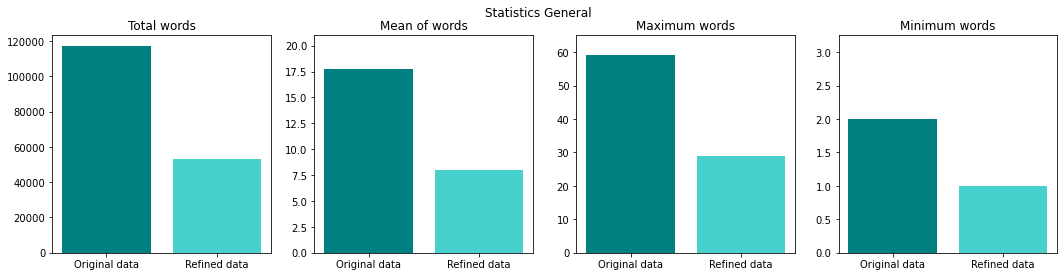

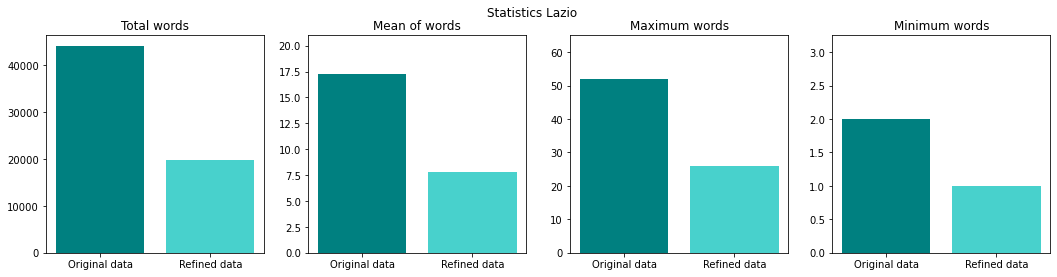

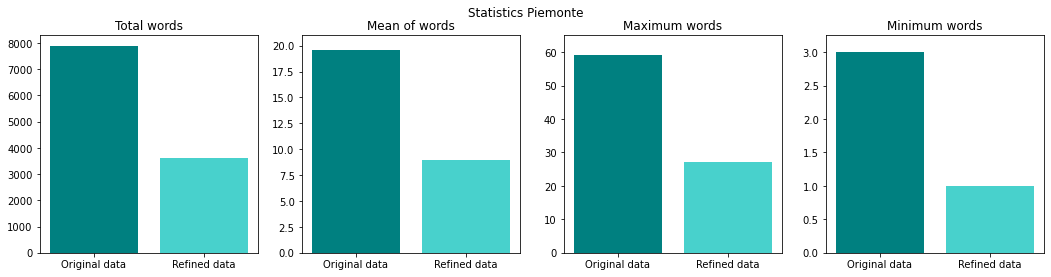

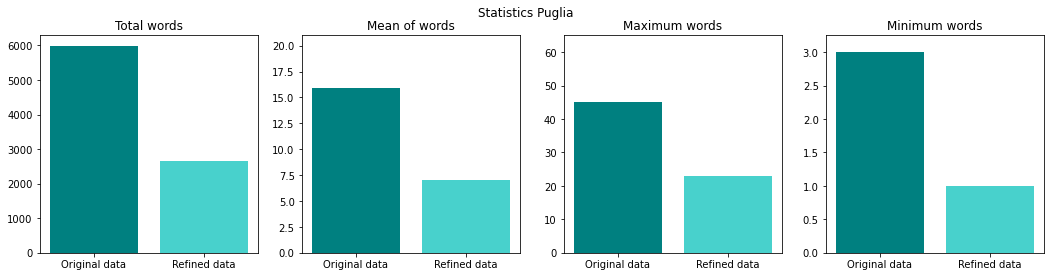

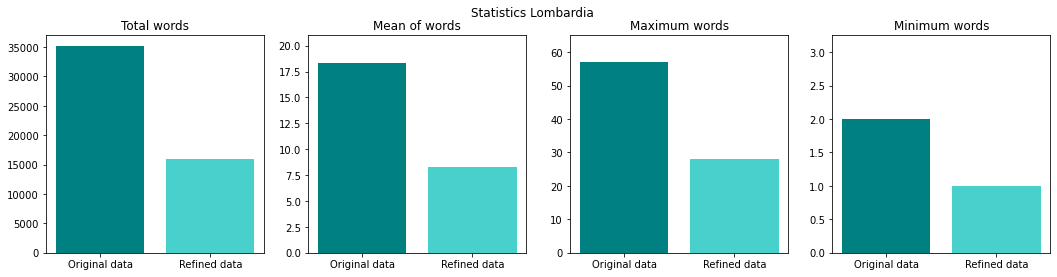

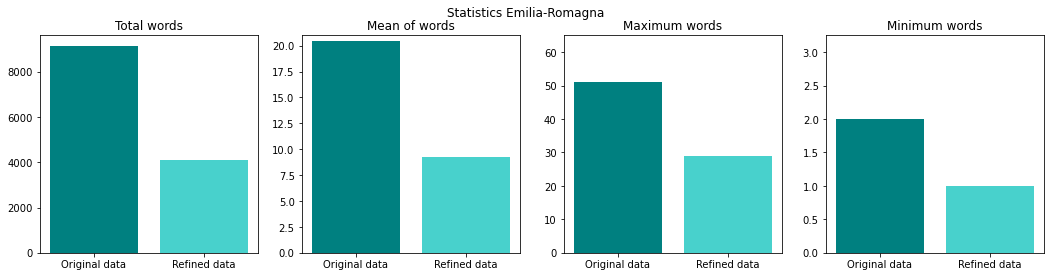

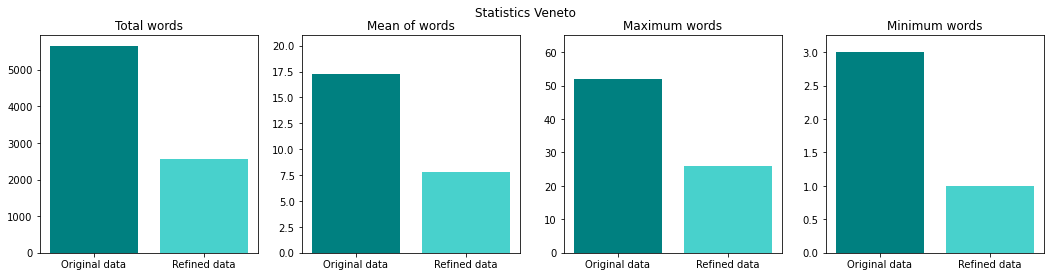

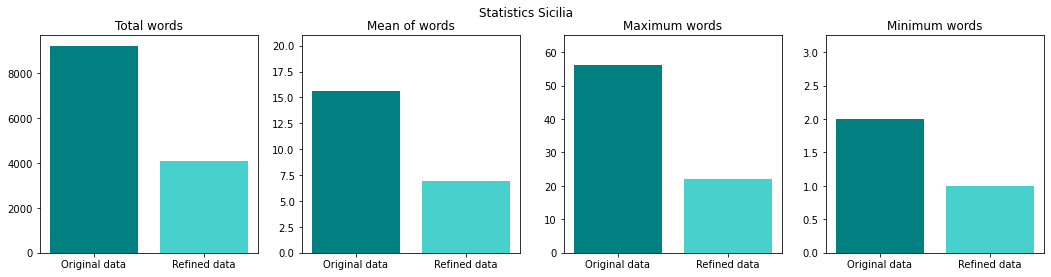

In [13]:
'Plots for general statistics'
plotstatistics(df_Sanremo, 'General')

'Plots for regional statistics'
for i in range(len(list(set(df_Sanremo['Region'])))):
    plotstatistics(df_Sanremo[df_Sanremo['Region'] == list(set(df_Sanremo['Region']))[i]], list(set(df_Sanremo['Region']))[i])

In [108]:
'''
There are already interesting results: we can immediately see that there are two dataset way bigger than the others: Lombardia
and Lazio, and this is probably due to the fact that these regions are way more populated and 'socially active'. The mean of
words is similar for every region (around 17.5 words per tweet in the oirignal and 7.5 in the refined), and also Max and Min
are pretty similar across regions. One interesting thing is that after the refining, even without applying POS, the mean number
of words is more than halved.
'''

In [15]:
'''
Now we're interested in relative frequency per length of the tweet. In these plots, we'll show the relative frequency of a plot
with a determined length. In this way, we'll understand which region tends to write longer or less about this topic.
'''

conto = {}

for j in list(set(df_Sanremo['Region'])):
    conto[j] = {}
    a = list(df_Sanremo[df_Sanremo['Region'] == f'{j}']['count_tweet_words'])
    
    for i in range(len(a)):
        if a[i] not in conto[j].keys():
            conto[j][a[i]] = (a.count(a[i]))
        else:
            continue

valori = [[(list(conto[j].values())[i]/np.sum(list(conto[j].values()))) for i in range(len(list(conto[j].values())))] for j in list(set(df_Sanremo['Region']))]

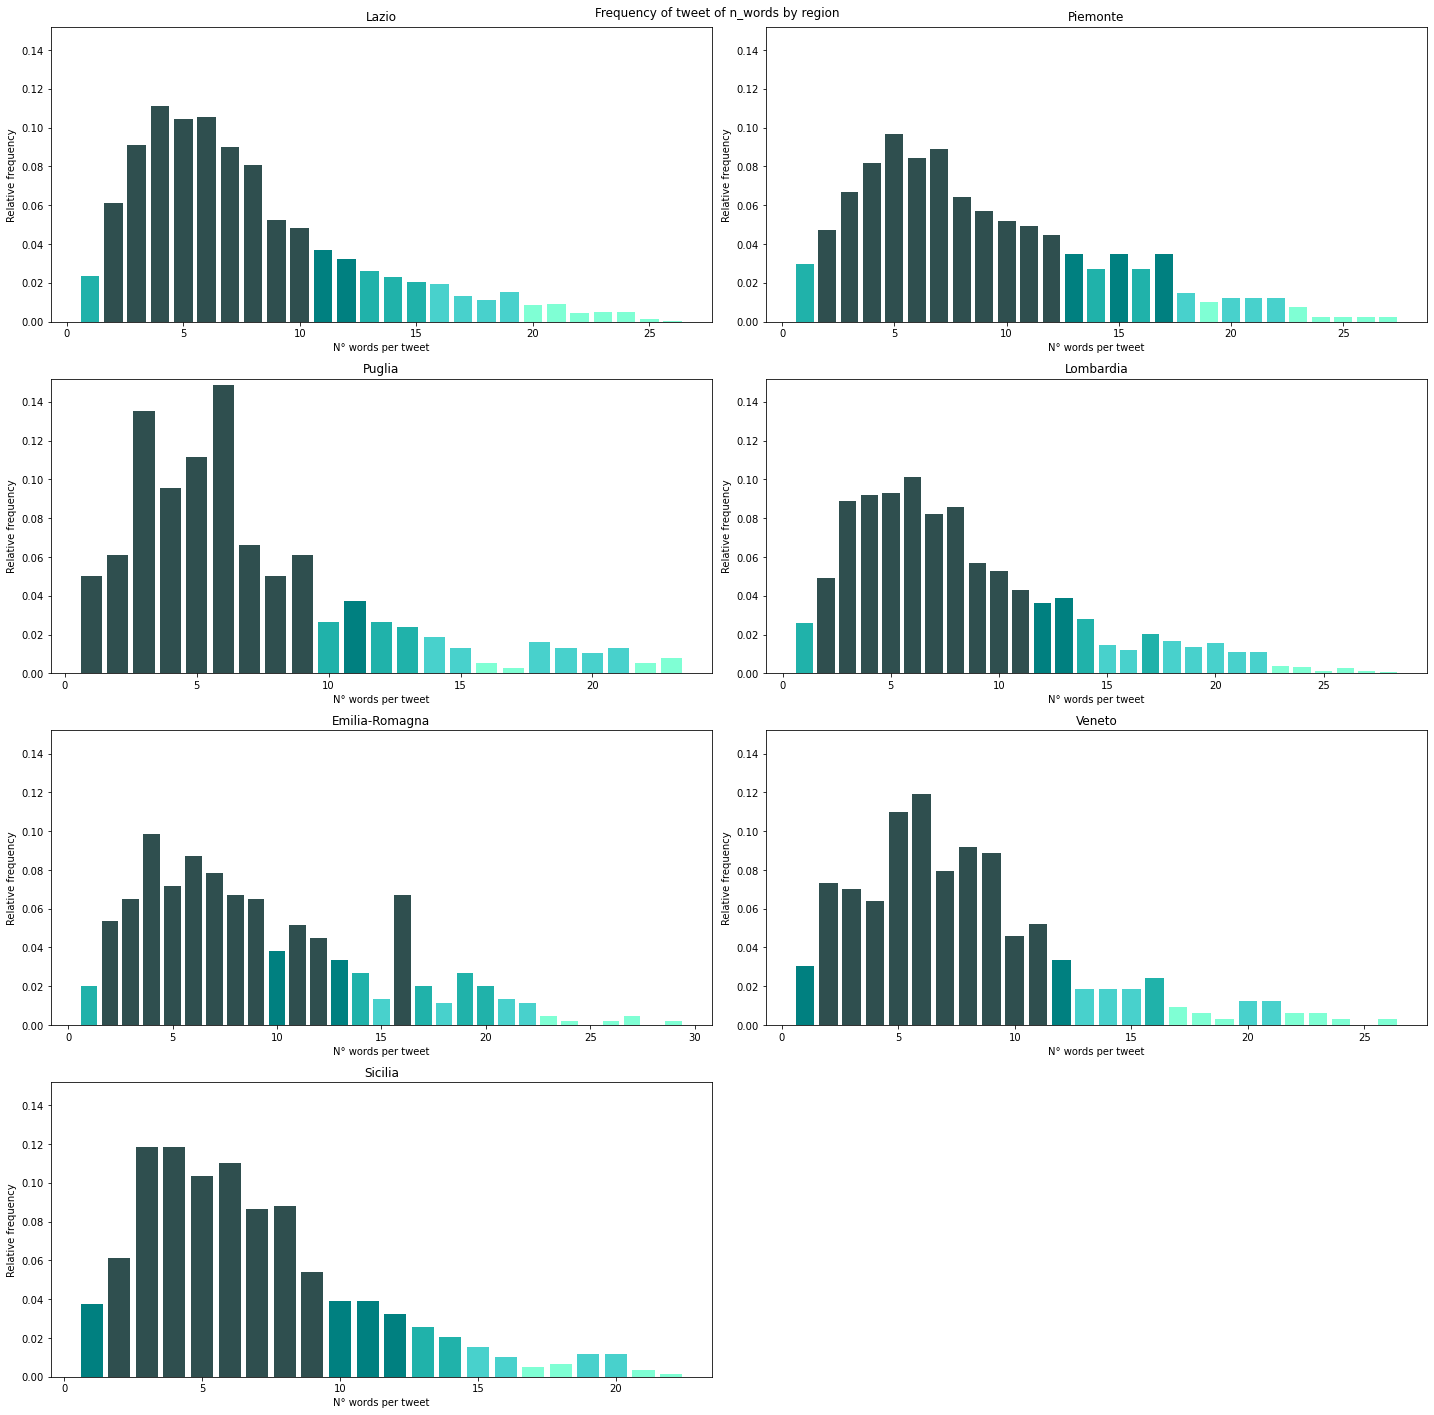

In [16]:
colors = [[] for i in range(len(valori))]

'The darker the color, the higher the relative frequency'

for j in range(len(valori)):
    for k in valori[j]:
        if k <= 0.01:
            colors[j].append('aquamarine')
        elif k > 0.01 and k <= 0.02:
            colors[j].append('mediumturquoise')
        elif k > 0.02 and k <= 0.03:
            colors[j].append('lightseagreen')
        elif k > 0.03 and k <= 0.04:
            colors[j].append('teal')
        elif k > 0.04:
            colors[j].append('darkslategray')
            
fig, axs = plt.subplots(4, 2, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.suptitle('Frequency of tweet of n_words by region')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(valori)):
    axs[j].set_title(f'{list(conto.keys())[j]}')
    axs[j].bar(conto[list(conto.keys())[j]].keys(),valori[j], color = colors[j])
    axs[j].set_xlabel('N° words per tweet')
    axs[j].set_ylabel('Relative frequency')
    axs[j].set_ylim([0, 0.152])
fig.delaxes(axs[7])
fig.tight_layout(pad=1.0)

In [107]:
'''
We can see that the behaviour is pretty similar across regions: after the refinement, most of the regions tend to have the
highest relative frequency around len = 5 or len = 7.5. There's only one strange outlier, that is the len = 16 in 
Emilia-Romagna, that maybe can suggest that people in that region tends to write a little bit more, on average, with respect to
the other regions
'''

In [18]:
'''
Now we take a look at the most common UNIGRAMS and BIGRAMS, firstly taking a look at general original data and general refined
data, and then going in depth into regions, in order to understand which were the most common UNIGRAMS and BIGRAMS in each 
of the analyzed regions
'''

'UNIGRAMS'
tokens_original = [[token.text for token in nlp(tweet)] for tweet in df_Sanremo['Original_tweet']]
tokens_refined = [[token.text for token in nlp(tweet)] for tweet in df_Sanremo['tweet']]

tokenizz1 = [item for sublist in tokens_original for item in sublist if item != ' ' and item != '' and item != '#']
tokenizz2 = [item for sublist in tokens_refined for item in sublist if item != ' ']

'BIGRAMS'
count1 = CountVectorizer(ngram_range=(2,2))
trasf = count1.fit_transform(df_Sanremo['tweet'])
REFINED_BIG = dict(sorted(dict(zip(count1.get_feature_names(),trasf.toarray().sum(axis=0))).items(), key=lambda item: item[1], reverse = True))
count2 = CountVectorizer(ngram_range=(2,2))
orig = count2.fit_transform(df_Sanremo['Original_tweet'])
ORIG_BIG = dict(sorted(dict(zip(count2.get_feature_names(),orig.toarray().sum(axis=0))).items(), key=lambda item: item[1], reverse = True))

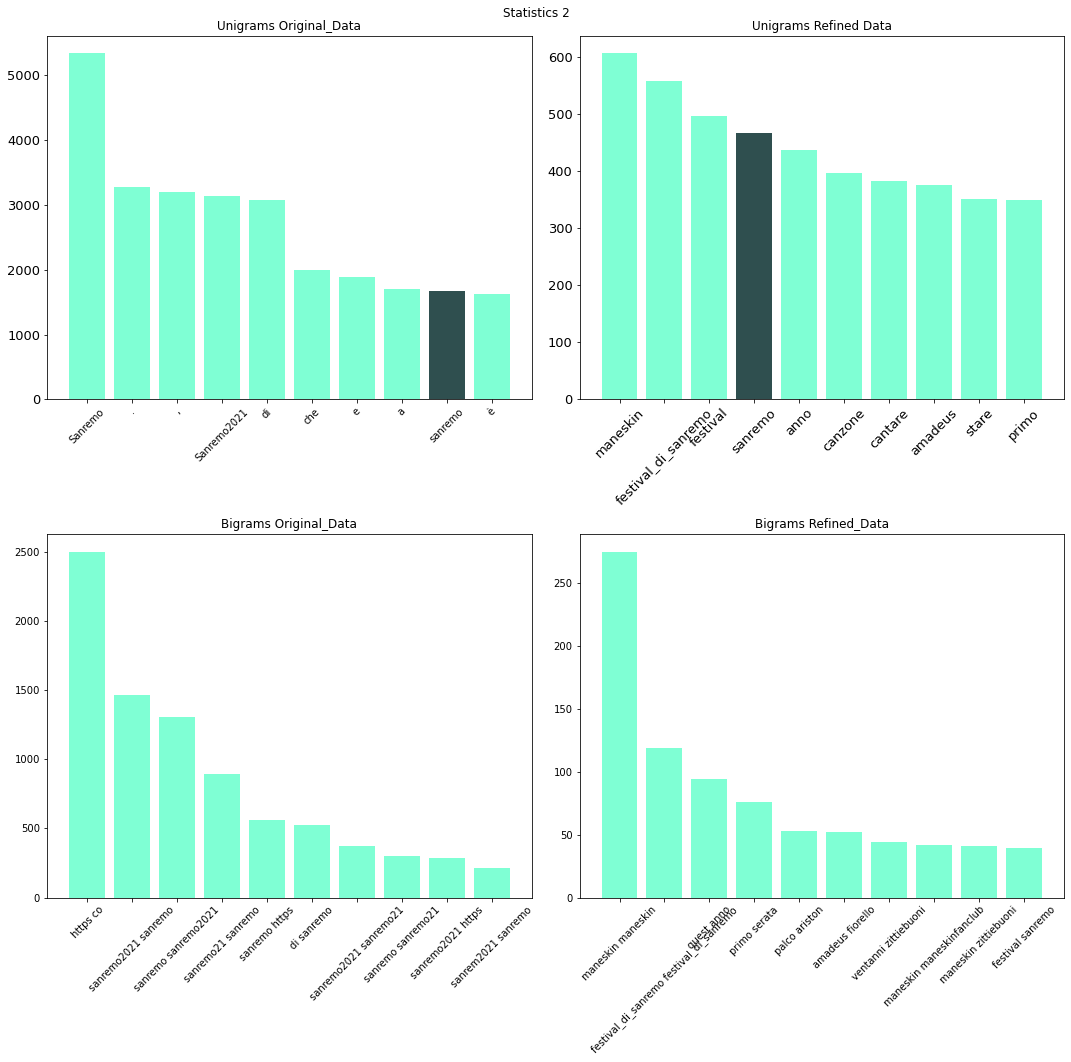

In [19]:
'''
Top 10 UNIGRAMS and BIGRAMS plots. If the color of the bar is darker, it means that the word is in common between the plot
for refined and original data
'''

fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.suptitle('Statistics 2')
axs = axs.ravel()
a = ['tab:orange']

colors1 = []
colors2 = []

for i in range(10):
    if (Counter(tokenizz1).most_common(10)[i][0] not in [j[0] for j in Counter(tokenizz2).most_common(10)]) == True:
        colors1.append('aquamarine')
    elif (Counter(tokenizz1).most_common(10)[i][0] in [j[0] for j in Counter(tokenizz2).most_common(10)]) == True:
        colors1.append('darkslategray')
for i in range(10):
    if (Counter(tokenizz2).most_common(10)[i][0] not in [j[0] for j in Counter(tokenizz1).most_common(10)]) == True:
        colors2.append('aquamarine')
    elif (Counter(tokenizz2).most_common(10)[i][0] in [j[0] for j in Counter(tokenizz1).most_common(10)]) == True:
        colors2.append('darkslategray')

ax = axs[0]
for i in range(2):
    ax.set_title('Unigrams Original_Data')
    ax.bar([i[0] for i in Counter(tokenizz1).most_common(10)],[i[1] for i in Counter(tokenizz1).most_common(10)], color = colors1)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[1]
for i in range(2):
    ax.set_title('Unigrams Refined Data')
    ax.bar([i[0] for i in Counter(tokenizz2).most_common(10)],[i[1] for i in Counter(tokenizz2).most_common(10)], color = colors2)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[2]
for i in range(10):
    ax.set_title('Bigrams Original_Data')
    ax.bar(list(ORIG_BIG.items())[i][0],list(ORIG_BIG.items())[i][1], color = colors1[0])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[3]
for i in range(10):
    ax.set_title('Bigrams Refined_Data')
    ax.bar(list(REFINED_BIG.items())[i][0],list(REFINED_BIG.items())[i][1], color = colors2[0])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
fig.tight_layout()

In [106]:
'''
From this statistic, we can see pretty interesting results: maneskin (the winners), is the most common unigram in the whole
dataset, but an interesting fact is that festival_di_sanremo, festival and sanremo (remember that these are not hashtags,
because we deleted the hastags containing these words) are the second, third and fourth most common unigrams, so people
tend to insert these words also in their text. The most common bigrams suggest an interesting result: Amadeus and Fiorello,
that were the two main presentors, position at the sixth place in the most common bigrams in refined text.
'''

In [21]:
'''
Now we're taking a look at the absolute frequency of unigrams in each region. If the color of a bar is dark, it means that the
word is in the top 10 of most used words even in another region. This means that the interesting columns are the clearer ones.
'''

A = {}
B = {}

for i in range(len(list(set(df_Sanremo['Region'])))):
    cv = [[] for i in range(len(list(set(df_Sanremo['Region']))))]
    cv_fit = [[] for i in range(len(list(set(df_Sanremo['Region']))))]
    cv[i].append(CountVectorizer())   
    cv_fit[i].append(cv[i][0].fit_transform(df_Sanremo[df_Sanremo['Region'] == list(set(df_Sanremo['Region']))[i]]['tweet'][:]))
    A[list(set(df_Sanremo['Region']))[i]] = dict(sorted(dict(zip(cv[i][0].get_feature_names(),cv_fit[i][0].toarray().sum(axis=0))).items(), key=lambda x: x[1], reverse=True))

for i in A.keys():
    B[i] = dict(zip(list(A[i].keys())[:10],list(A[i].values())[:10]))

In [22]:
'Let s create a list of common keys'

common_keys = []
for j in B.keys():
    for k in B[j].keys():
        common_keys.append(k)
        
d = [(i,common_keys.count(i)) for i in common_keys]

COMUNI = [list(set(d))[i][0] for i in range(len(list(set(d)))) if list(set(d))[i][1] > 1]

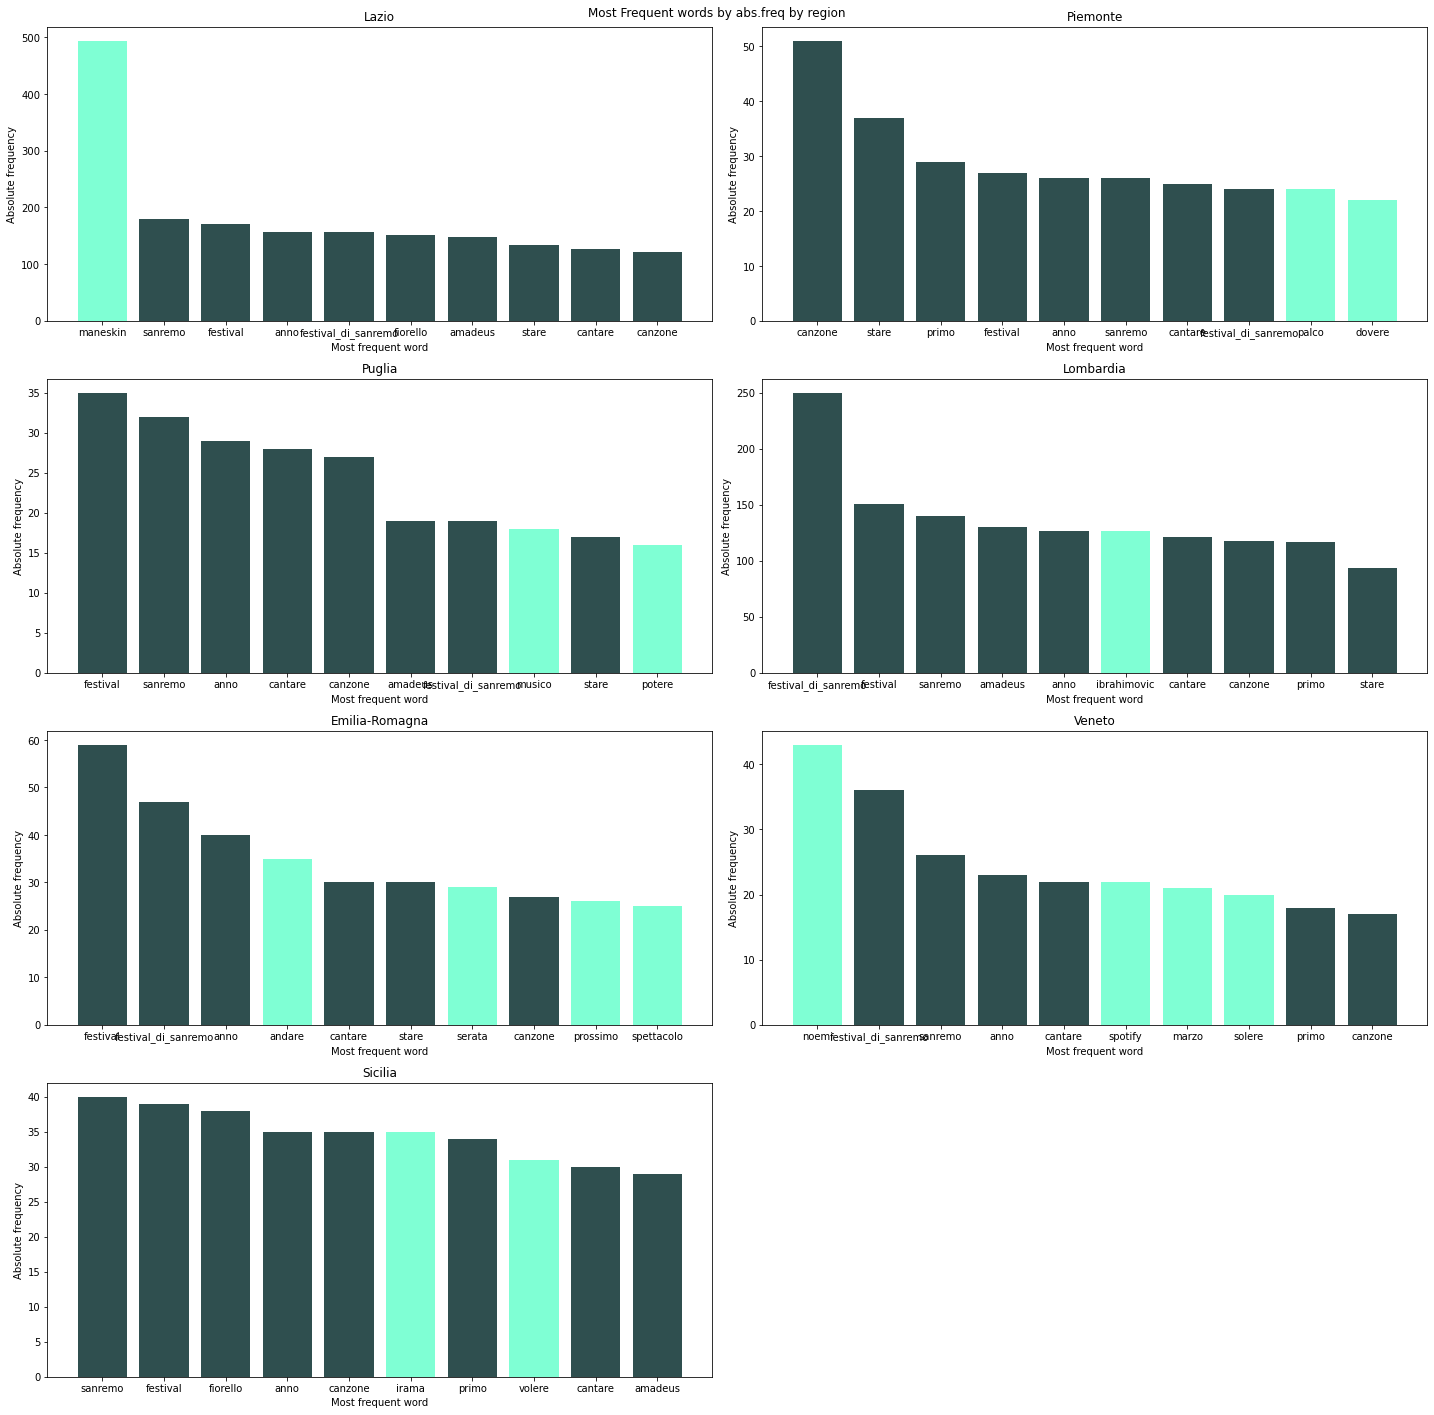

In [23]:
'''
Plot for absolute frequency of most common unigrams in each region. If the color of a bar is clearer, than it means that
that word appears just in the top 10 of that region, and in none of the others.
'''

colors1 = [[] for i in range(len(valori))]

for j in range(len(list(B.keys()))):
    for k in B[list(B.keys())[j]].keys():
        if k in COMUNI:
            colors1[j].append('darkslategray')
        else:
            colors1[j].append('aquamarine')

fig, axs = plt.subplots(4, 2, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.suptitle('Most Frequent words by abs.freq by region')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(valori)):
    axs[j].set_title(f'{list(B.keys())[j]}')
    axs[j].bar(B[list(B.keys())[j]].keys(),B[list(B.keys())[j]].values(), color = colors1[j])
    axs[j].set_xlabel('Most frequent word',fontsize=10)
    axs[j].set_ylabel('Absolute frequency',fontsize=10)  
fig.delaxes(axs[7])
fig.tight_layout(pad=1.0)

In [105]:
'''
Here we have the first really interesting results: Maneskin is by far the most used word in Lazio, and it doesn't appear
in none of the other regions: probably these suggest that lots of Maneskin's votes came from that region. Other interesting
thing is that NOEMI is the most used word in Veneto, and IRAMA is nearly the most used one in Sicilia, and none of the other
regions present in their top 10 neither Noemi nor Irama.
'''

## 2. Analysis / Visualization

During the analysis, I'm going to try to understand if there was a difference in regions' behaviours, but I'll also try to understand the general sentiment of Italian people when they tweet about the most important festival in italian history. I'll apply different methods in order to get to a solution: **Word embeddings**, **Document embeddings**, **TFIDF analysis**, **Dimensionality Reduction**, **Topic model**, **Author Topic Model**, **Clustering**, **Language model**, **Matrix Factorization** and **Sentiment Analysis**. 

Thanks to all these different approaches, I'll try to build a general overview of the relationship between italian Tweeters and Sanremo.

### 1) TFIDF

In [25]:
'''
Let s start from a TF-IDF analysis. I decided to raise the parameter in max_df since I don't have a big corpus, and my text
is highly refined, so I'm confident I can keep in count terms that have a document frequency very high. Moreover, I'll keep 
count also of Bigrams, to compare the results with Unigrams.
'''

def TFIDF(text,title, value1 = 0,value2 = 0,dim1 = 20, dim2 = 10):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.95, 
                                   ngram_range=(1,2),
                                   stop_words=None, 
                                   sublinear_tf=True)
    X = tfidf_vectorizer.fit_transform(text)
    vectorizer = CountVectorizer(analyzer='word', 
                             min_df=0.001, 
                             max_df=0.95,
                             ngram_range=(1,2),
                             stop_words=None)
    X2 = vectorizer.fit_transform(text)
    df_Confronto = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf'])
    df_Confronto = df_Confronto.reset_index()
    df_Confronto = df_Confronto.drop(['index'],axis=1)
    tfidf = [i for i in df_Confronto['tfidf']]
    list_of_words = [i for i in df_Confronto['word']]
    idf = [i for i in df_Confronto['idf']]
    tf = [i for i in df_Confronto['tf']]
    
    colors3 = []
    
    for j in range(len(tfidf)):
        if tfidf[j] < 70 and len(df_Confronto['word'][j].split()) == 1:
            colors3.append('aquamarine')
        elif tfidf[j] >= 70 and  tfidf[j] < 100 and len(df_Confronto['word'][j].split()) == 1:
            colors3.append('lightseagreen')
        elif tfidf[j] >= 100 and len(df_Confronto['word'][j].split()) == 1:
            colors3.append('darkslategray')
        elif tfidf[j] < 70 and len(df_Confronto['word'][j].split()) == 2:
            colors3.append('lightsalmon')
        elif tfidf[j] >= 70 and  tfidf[j] < 100 and len(df_Confronto['word'][j].split()) == 2:
            colors3.append('sienna')
        elif tfidf[j] >= 100 and len(df_Confronto['word'][j].split()) == 2:
            colors3.append('saddlebrown')        
    
    area = [1.5*10*tfidf[n] for n in range(len(tfidf))]
    
    # Plot
    plt.figure(figsize=(dim1,dim2))
    plt.scatter(tfidf, idf, s=area, c=colors3, edgecolors='b')
    plt.title(f'Scatter plot TFIDF-IDF {title}')
    for i in range(-5,0):
        plt.annotate(df_Confronto['word'].iloc[i], (tfidf[i], idf[i]), (tfidf[i]+ value1,idf[i]+ value2))
    plt.xlabel('TFIDF')
    plt.ylabel('IDF')
    plt.show()

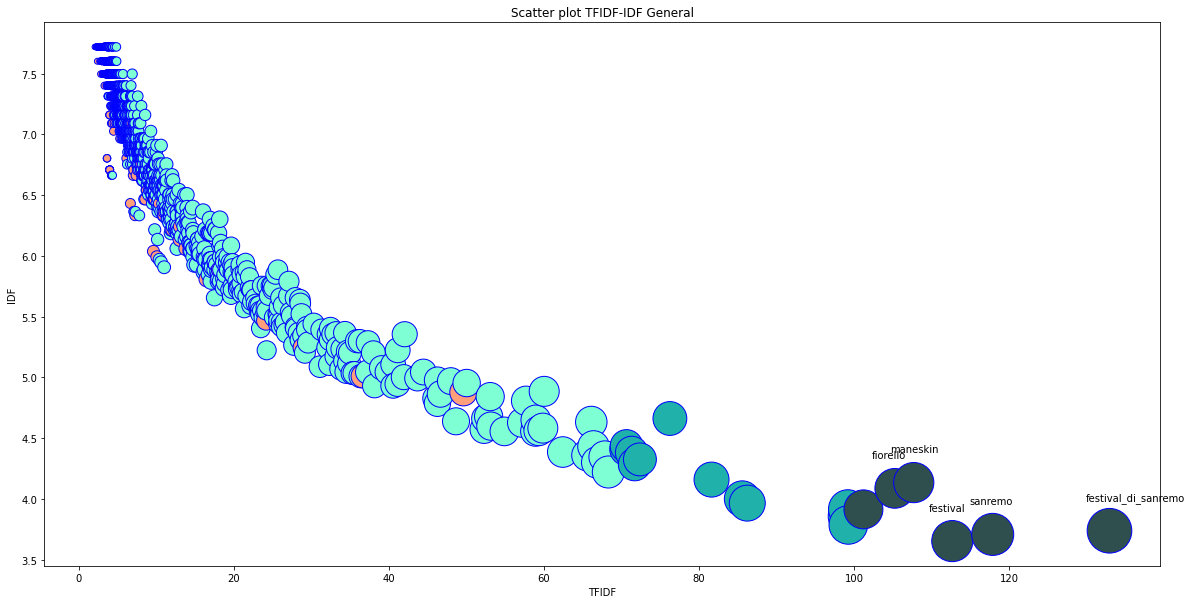

In [26]:
'TFIDF analysis for the whole dataset'

text_cleaned = [i for i in df_Sanremo['tweet']]

TFIDF(text_cleaned,'General', -3, +0.25)

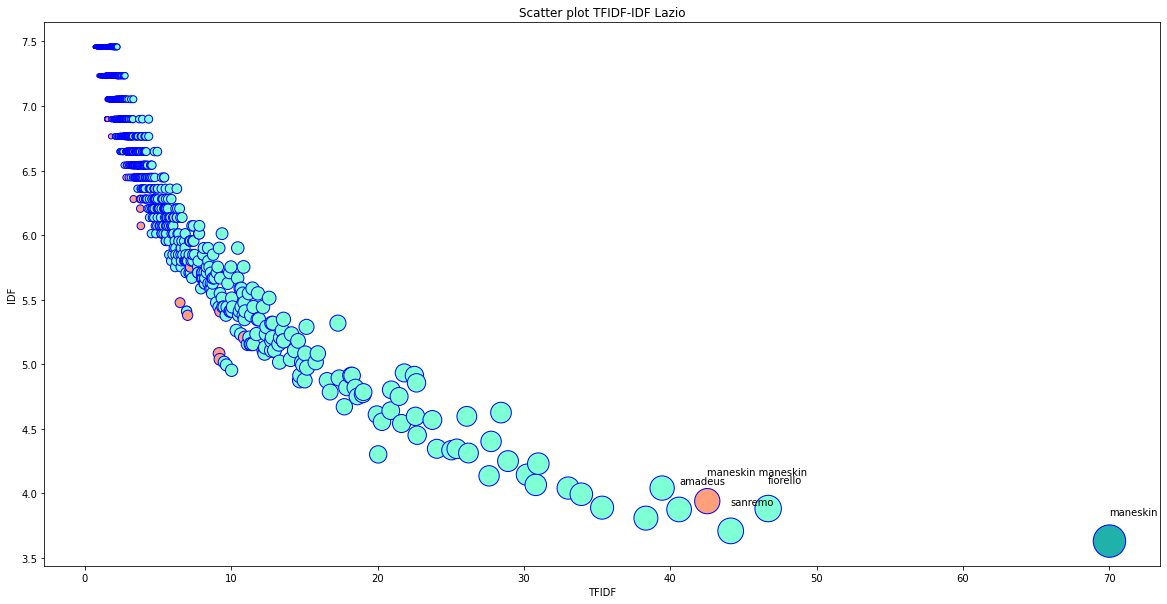

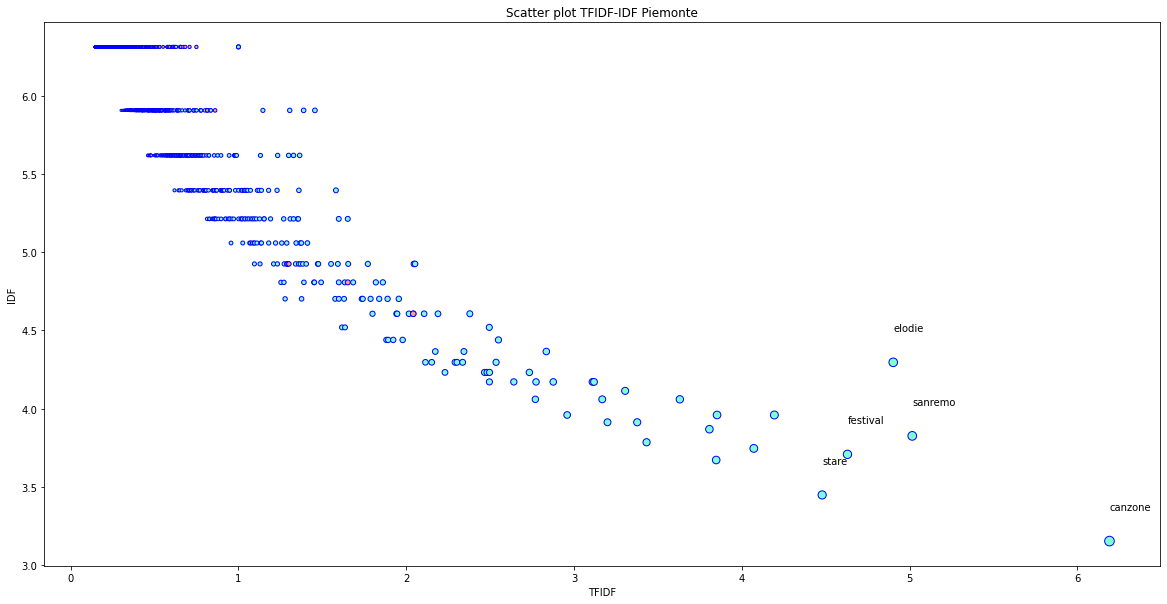

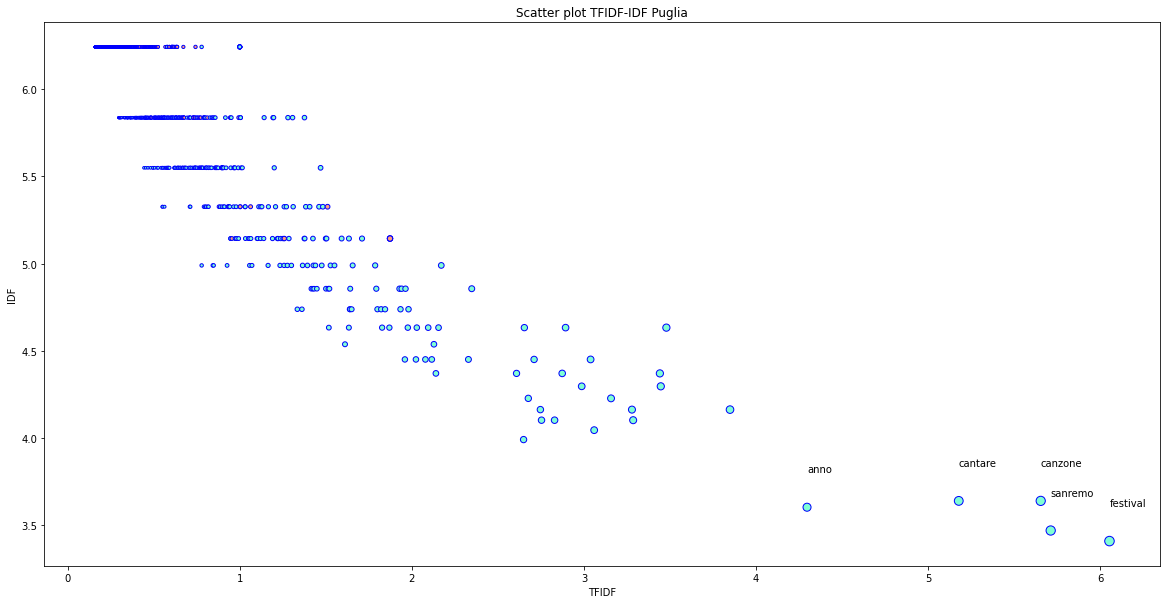

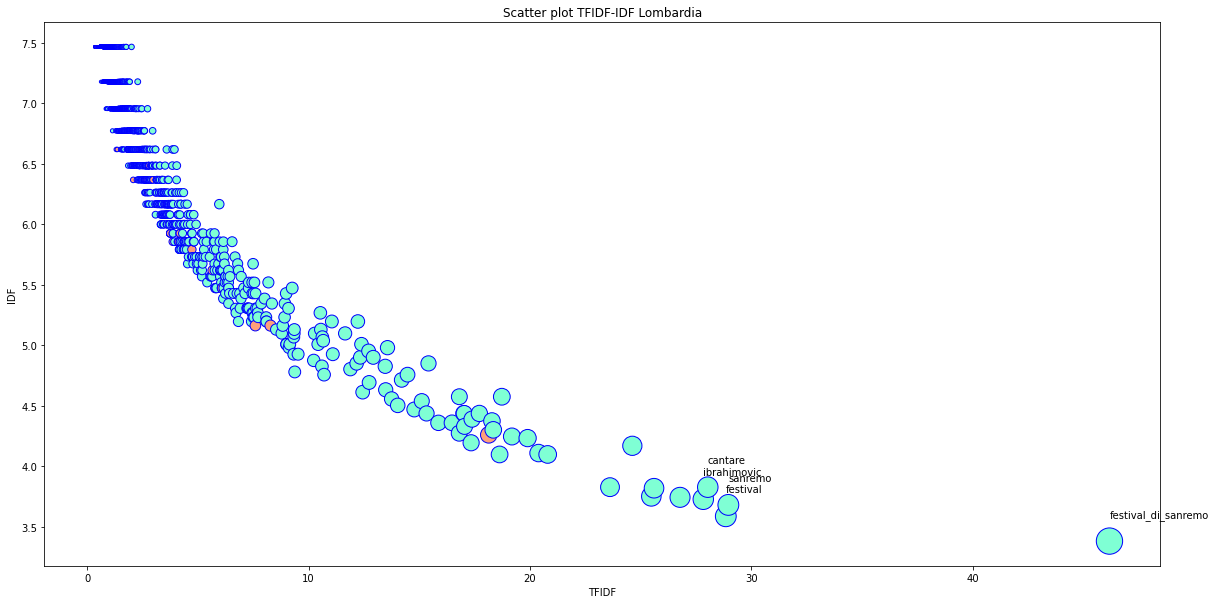

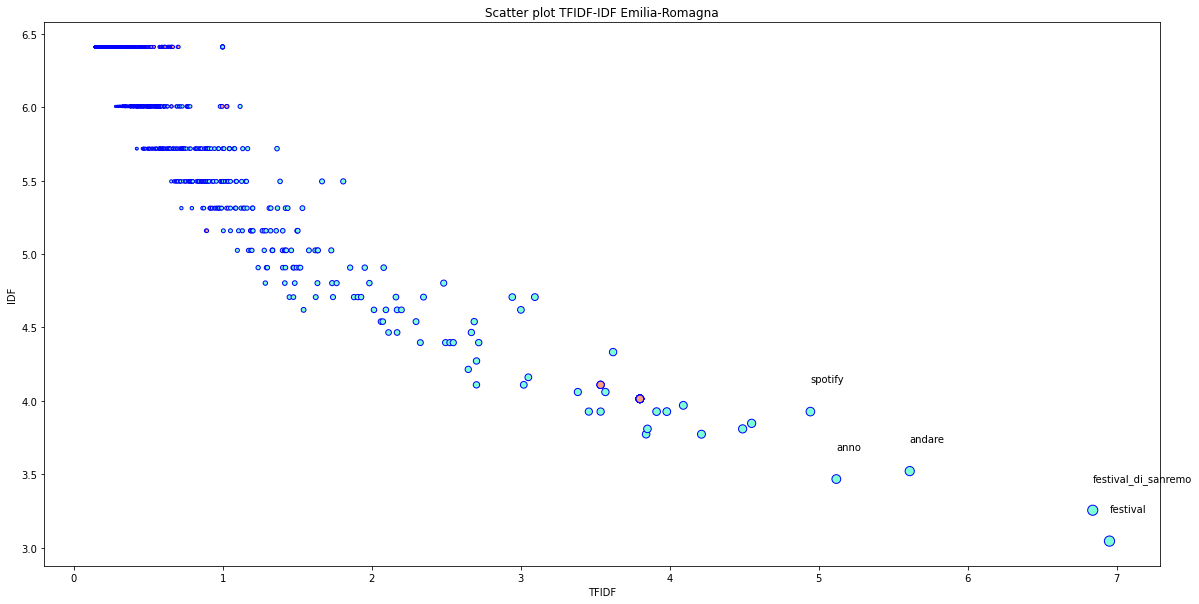

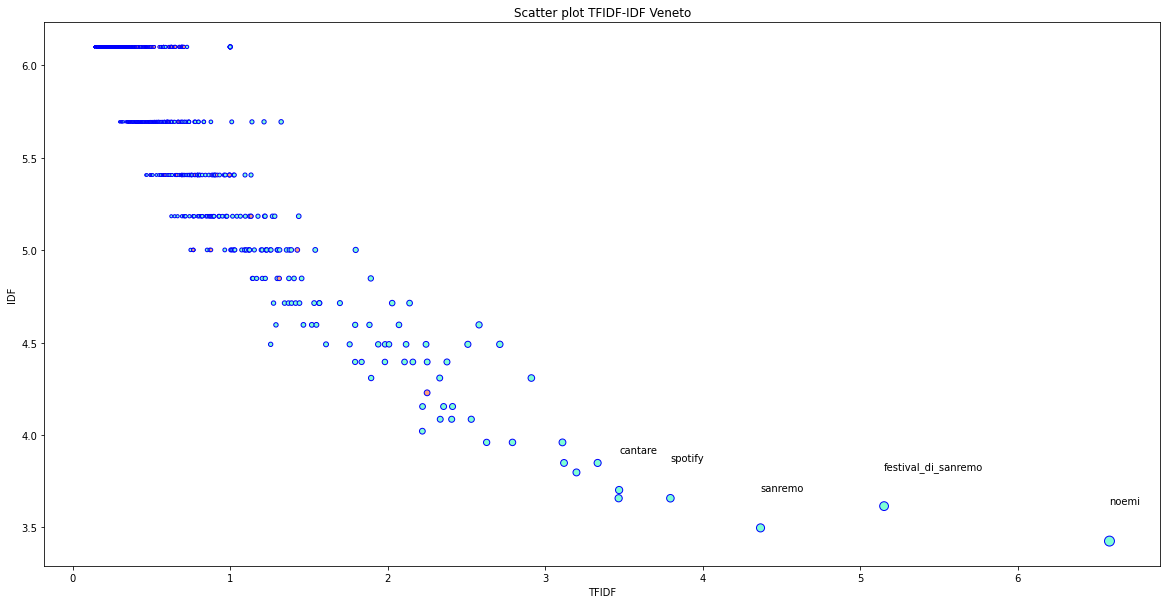

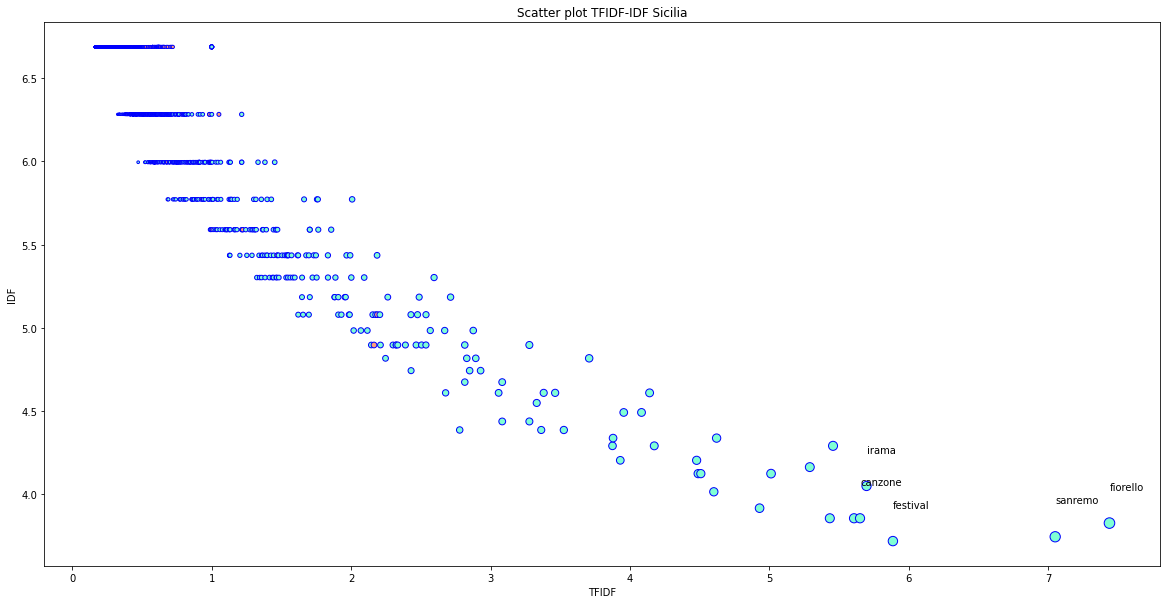

In [27]:
'TFIDF analysis applied to each singular region'

text_cleaned = {}
for j in list (set(df_Sanremo['Region'])):
    text_cleaned[j] = [i for i in df_Sanremo[df_Sanremo['Region'] == j]['tweet']]

for j in list(set(df_Sanremo['Region'])):
    TFIDF(text_cleaned[j], j, 0, 0.2, 20,10)

In [104]:
'''
As you can see from the below plot, top 3 words for TFIDF in the whole dataset where festival_di_sanremo, festival and sanremo,
probably a result that we could expect. Way more interesting is the fact that Maneskin appears in the top-5, and this respects
our prior-knowledge, since they were the winners. Another interesting thing is the positioning of Ibrahimovic in Lombardia:
we know he's a famous football player for A.C. Milan, and he was a special guests for the whole duration of Sanremo. People
in Lombardia probably wrote more about him, with respect to the other regions.
'''

### 2 / 3) Word2Vec + Dimensionality Reduction

In [29]:
'''
Word2Vec analysis via PCA. We firstly average 5 word2vec model, changing every time the seed. Moreover, for each Word2Vec model
i'll change the window and the negative value. Since the average length of the refined tweets is 7.5, I set a starting value
for the window of 1, in order to go from a window value of 2 to a window value of 7. Since we're considering all the dataset, 
I can keep a min_count value quite high. The averaging will be important in order to get results that are similar each time 
we run the code. Inside the PCA, we will put the 10 most similar words to the words we decide. 
'''
import warnings
warnings.simplefilter('always')
warnings.filterwarnings('ignore')

corpus = [i.lower().split() for i in df_Sanremo['tweet']]

list_of_models = []

for i in range(5):
    w2v_model = Word2Vec(size=300, # vector size
                     window=2 + i, # window for sampling
                     sample=0.00001, # subsampling rate
                     iter=300, # iterations
                     negative=5 - i, # negative samples
                     min_count=80, # minimum threshold
                     workers=-1, # parallelize to all cores
                     hs=0, # no hierarchical softmax
                     seed = i+5
                    )
    
    # build the vocabulary
    w2v_model.build_vocab(corpus)
    
    # train the model
    w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)
    
    list_of_models.append(w2v_model)

listone = []

for i in range(len(list_of_models[0].wv.syn0)):
    listone.append(list(np.sum(list_of_models[j].wv.syn0[i] for j in range(len(list_of_models)))/len(list_of_models)))
    
listone = np.array(listone)

for i in range(len(list_of_models[4].wv.syn0)):
    list_of_models[4].wv.syn0[i] = listone[i]
    
w2v_model = list_of_models[4]

In [30]:
'''
By dimensionality reduction, we will understand where the 10 most similar words to the words with highest TFIDF locate in the
space.
'''

from pylab import * # Importing this just to put the rectangle around the figure

def PCA_scatterplot(word, num_similar):
    vocab = list(w2v_model.wv.vocab.keys())
    vocab_len = len(vocab)
    dim0 = w2v_model.wv[vocab[0]].shape[0]
    arr = np.empty((0, dim0), dtype='f')
    w_labels = [word]
    nearby = w2v_model.wv.similar_by_word(word, topn=num_similar)
    arr = np.append(arr, np.array([w2v_model.wv.__getitem__(word)]), axis=0)
    for n in nearby:
        w_vec = w2v_model.wv.__getitem__(n[0])
        w_labels.append(n[0])
        arr = np.append(arr, np.array([w_vec]), axis=0)
  
    pca = PCA(n_components=2, whiten = True, svd_solver = 'randomized', random_state = 42)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    return w_labels, x_coords , y_coords

def plot_funct(lista):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    ax.axis('off')
    color1 = ['darkblue','green','red','goldenrod','skyblue']
    color2 = ['blue','lime','darksalmon','gold','steelblue']
    area = [(10*i**2.5) for i in reversed(range(1,9))]
    for i in range(len(lista)):
        ax.scatter(lista[i][1][1:], lista[i][2][1:], s=area, marker="o", color=color2[i], label = f'{lista[i][0][0]}', edgecolors='black')
        for label, x, y in zip(lista[i][0][1:], lista[i][1][1:], lista[i][2][1:]):
            ax.annotate(label.upper(), xy=(x, y), xytext=(0, 15), textcoords='offset points', size=12)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, prop={'size': 25})  
    ax.axis('off')
    ax.grid(True)
    autoAxis = ax.axis()
    rec = Rectangle((autoAxis[0]-0.05,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+0.2,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=2)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)

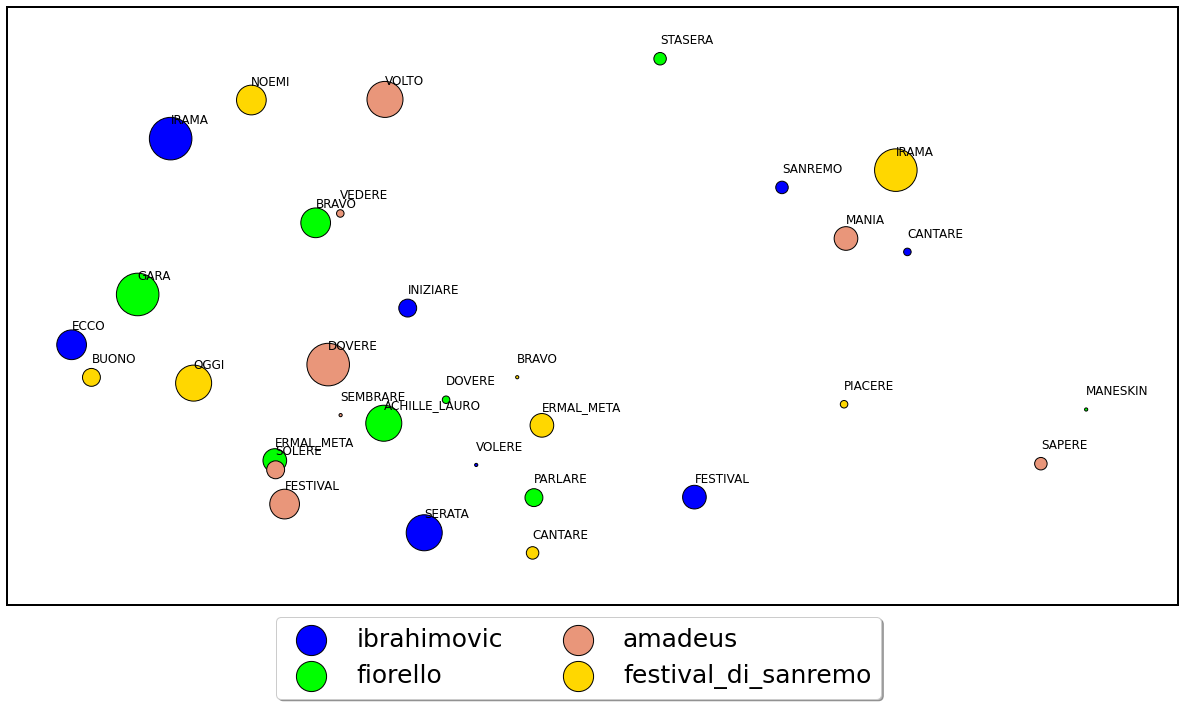

In [31]:
'Plot for PCA dimensionality reduction'

lista = [PCA_scatterplot('ibrahimovic',8),PCA_scatterplot('fiorello',8),\
         PCA_scatterplot('amadeus',8),PCA_scatterplot('festival_di_sanremo',8)]

plot_funct(lista)

In [103]:
'''
From the plot of the 10 most similar words for Ibrahimovic, Amadeus, Fiorello and Festival_di_sanremo, we can see that there's
a nearness in space between Fiorello, Ibrahimovic and Amadeus most similar word.Festival_di_sanremo appears to be more far away
from the others.
'''

### 4) Doc2Vec

In [33]:
'''
Since we removed the tags from the text, I decided to rebuild the dataset, so that tweets that had multiple tags appeared
the same times as the number of tags they had, so that every single tag was connected to the single tweet. In this way, I could
undestand, thanks to Doc2Vec properties, the 10 most similar words for each region to @SanremoRai, the official account of
Sanremo, and compare the results. 
'''

lista_users = list(df_Sanremo['user_mentioned'])
removing_comas = [lista_users[i].replace(',', ' ') for i in range(len(lista_users))]
    
tokens1 = [[word.text for word in nlp(tag)]
          for tag in removing_comas]

len_of_tok = [len(tokens1[i]) for i in range(len(tokens1))]
    
refining_text = [[i, len_of_tok[i]] for i in range(len(len_of_tok)) if len_of_tok[i] > 1]

f = []

for i in range(len(refining_text)):
    f.append(pd.concat([df_Sanremo.iloc[(refining_text[i][0]):(refining_text[i][0]+1),:]]*((refining_text[i][1])-1)))
    
f = pd.concat(f)
a = pd.DataFrame(f)

nuovo_dataframe_sanremo = pd.concat([df_Sanremo,a],axis=0)
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.sort_values(by = ['Region','id'],ascending = True)
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.reset_index()
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.drop(['index'],axis=1)

A = list(nuovo_dataframe_sanremo['user_mentioned'])
G = [A[i].replace(',', ' ').lower() for i in range(len(A))]
    
tokens2 = [[word.text for word in nlp(tag.lower())]
          for tag in G]

n_d_f = nuovo_dataframe_sanremo

n_d_f['num'] = pd.Series(tokens2)
n_d_f['count'] = n_d_f.groupby('id').cumcount()

n_d_f['user_mentioned'] = n_d_f.apply(lambda x: x['num'][x['count']] if len(x['num'])>0 else '', axis=1)

n_d_f = n_d_f.drop(['num','count'],axis=1)

In [34]:
'''
Now that we have another dataset, we build a Doc2Vec model for every region, where the TAG of each document is the 
single user_mentioned. We will compare the 10 most similar words to @SanremoRai for each region, in order to understand if they
change. We set a window of 3, since the average len of tweets is 7.5, while this time I decided to lower the min_count to 20, 
since there are some regions that present a lower number of tweets compared to Lazio and Lombardia
'''

def d2vmodelfunc(regione):
    corpus = []
    
    for row in n_d_f[n_d_f['Region'] == regione].iterrows():
        label = row[1].user_mentioned
        text = row[1].tweet
        corpus.append(TaggedDocument(words=text.split(), 
                                     tags=[str(label)]))
    
    d2v_model = Doc2Vec(vector_size=300, 
                        window=3,
                        hs=0,
                        sample=0.00001,
                        negative=5,
                        min_count=20,
                        workers=-1,
                        epochs=500,
                        dm=0, 
                        dbow_words=1)
    
    d2v_model.build_vocab(corpus)
    
    d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    
    return d2v_model

dizio = {}
for i in list(set(df_Sanremo['Region'])):
    dizio[i] = d2vmodelfunc(i).most_similar(positive=[d2vmodelfunc(i).docvecs['sanremorai']], topn=10)

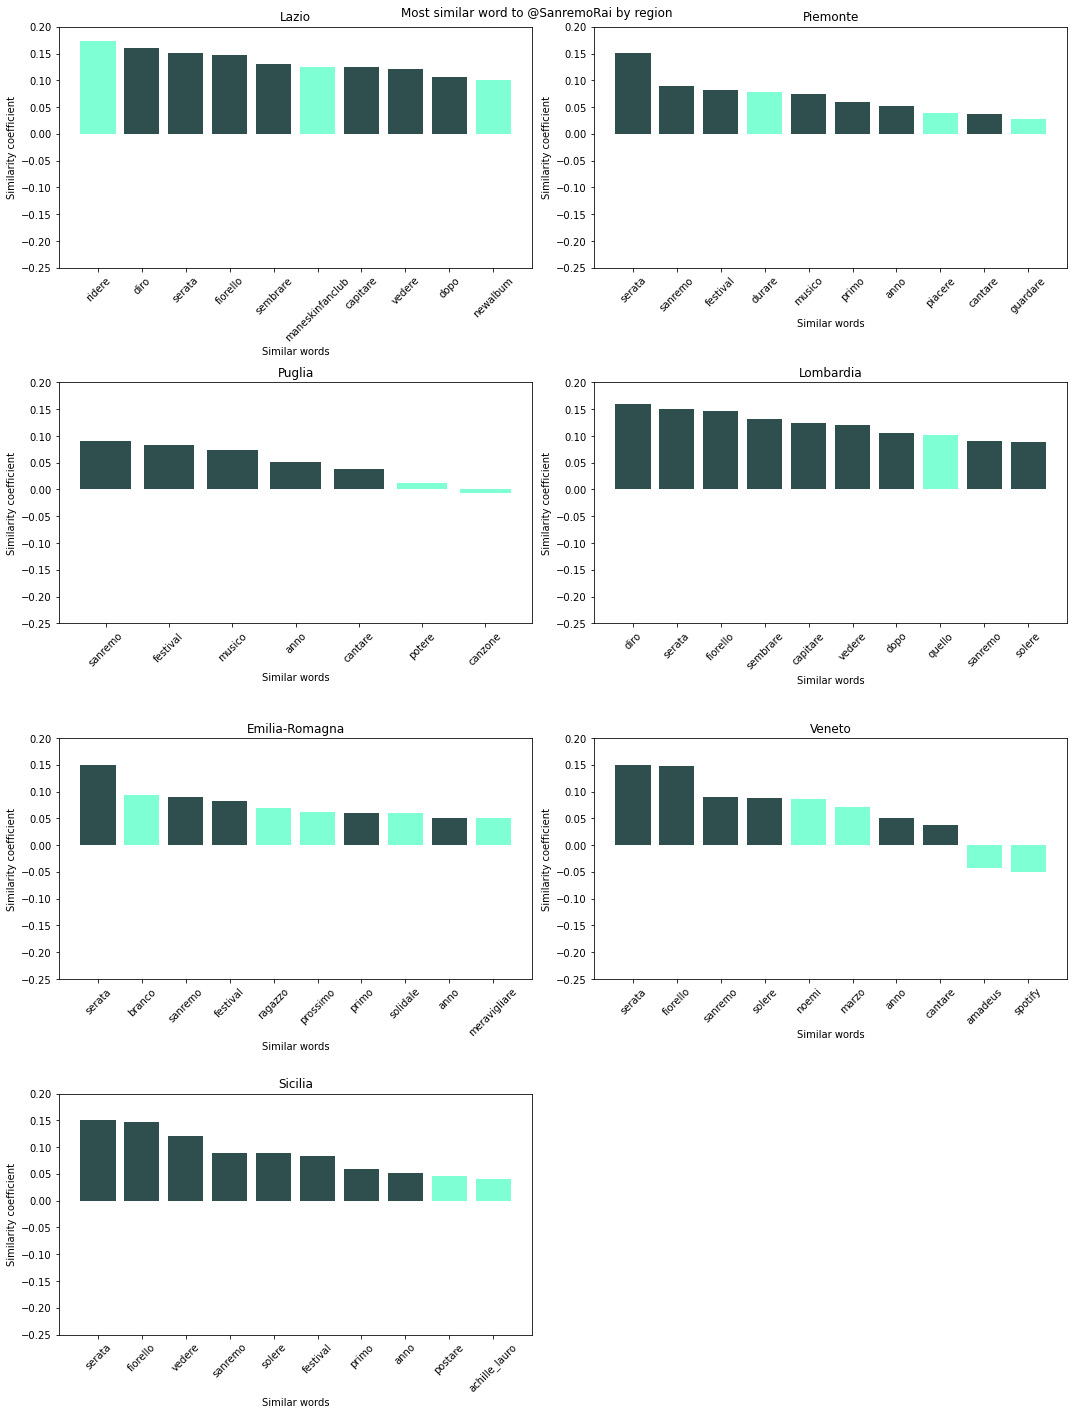

In [35]:
'Plot for Doc2Vec similarity'

A = [ele for sublist in list(dizio.values()) for ele1 in sublist for ele in ele1]
A = [A[i] for i in range(len(A)) if i%2==0]
COMMON = []
for i in range(len(Counter(A))):
    if list(Counter(A).values())[i] > 1:
        COMMON.append(list(Counter(A).keys())[i])

colors = [[] for i in range(len(list(dizio.values())))]
for i in range(len(list(dizio.values()))):
    for j in range(len(list(dizio.values())[i])):
        if (list(dizio.values())[i][j][0] in COMMON) == True:
            colors[i].append('darkslategray')
        else:
            colors[i].append('aquamarine')
            
elements1 = [[] for i in range(len(list(dizio.values())))]
elements2 = [[] for i in range(len(list(dizio.values())))]
for i in range(len(list(dizio.values()))):
    for j in range(len(list(dizio.values())[i])):
        elements1[i].append((list(dizio.values())[i][j][0]))
        elements2[i].append((list(dizio.values())[i][j][1]))
        

fig, axs = plt.subplots(4, 2, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.suptitle('Most similar word to @SanremoRai by region')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(dizio)):
    axs[j].set_title(f'{list(dizio.keys())[j]}')
    axs[j].bar(elements1[j],elements2[j], color = colors[j])
    axs[j].set_xlabel('Similar words')
    axs[j].set_ylabel('Similarity coefficient')  
    axs[j].set_ylim([-0.25,0.2])
    for tick in axs[j].get_xticklabels():
        tick.set_rotation(45)
fig.delaxes(axs[7])
fig.tight_layout(pad=1.0)

### 5) Language Model

In [36]:
'''
Here we build a language model, where we try to understand if the generation of a tweet basing on the location (so building
the algorithm every time with the tweets of each single region) gives different results.
'''

def prediction(database):
    smoothing = 0.00001
    START = '_***_'
    STOP = '_STOP_'
    
    counts = defaultdict(lambda: defaultdict(lambda: smoothing))
    
    corpus = [tweet.strip().split() for tweet in database]
    
    for sentence in corpus:
        
        tokens = [START, START] + sentence + [STOP]
        
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1
            
    def generate():
        """
        generate a new sentence
        """ 
        result = [START, START]
        
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)
        
        while next_word != STOP:
            next_word = sample_next_word(result[-2], result[-1])
            result.append(next_word)
        
        return ' '.join(result[2:-1])
            
    def sample_next_word(u, v):
        """
        sample a word w based on the history (u, v)
        """
        
        keys, values = zip(*counts[(u, v)].items())
        
        values = np.array(values)
        values /= values.sum() 
        
        sample = np.random.multinomial(1, values) 
        
        return keys[np.argmax(sample)]
    
    return generate()

In [37]:
'''
Now that we built the algorithm, we can print a 'predicted tweet' for every region.
'''

for i in list(set(df_Sanremo['Region'])):
    print('Prediction for {}:'.format(i))
    print(' ')
    print(prediction(df_Sanremo[df_Sanremo['Region'] == i]['Original_tweet']))
    print(' ')
    print('---------')

Prediction for Lazio:
 
C'ho avuto 'na soffiata: nella prossima stagione de' #LaCasaDePapel, i protagonisti c'avranno la maschera de @MaxGazze! Vero @NetflixIT? #ecchessanremo #Sanremo2021 #Sanremo21 #Sanremo #Sanremo2021
 
---------
Prediction for Piemonte:
 
A me @Ibra_official piace 🤩😍 A prescindere una che ci ha regalato, era veramente un sex simbols della canzone è interessante, però mi ricorda loro. Secondo voi 🤔 #Sanremo2021 #Sanremo
 
---------
Prediction for Puglia:
 
#AchilleLauro continua a fare omaggi, il bello però è che non sarà mai famosa come suo cugino Trottolino #Sanremo21 #Sanremo #festivaldisanremo2021 #FestivalDiSanremo
 
---------
Prediction for Lombardia:
 
#ansia per il sound e per l'occasione ripercorriamo alcuni degli ospiti più attesi dai nostri follower Twitter XD #Sanremo2021 #sanremo
 
---------
Prediction for Emilia-Romagna:
 
Stasera (forse!!!) do un’occhiata a #Sanremo https://t.co/fh6dDZqfcs via @slyvicom
 
---------
Prediction for Veneto:
 
Senza pubb

In [38]:
'''
In order to evaluate this prediction, I'll use a function that I build mainly for the Sentiment Analysis part (meanofatext), 
where I compute the average compound value given a certain text. This time, I'll just compute the average compound value over
300 generated tweets for every region, and compare the outcome. TAKES TIME
'''

def meanofatext(text):
    lista_comp = []
    sia = SentimentIntensityAnalyzer()
    for i in range(len(text)):
        lista_comp.append(sia.polarity_scores(text[i])['compound'])
    return np.mean(lista_comp)

list_of_predictions = [[] for i in range(len(list(set(df_Sanremo['Region']))))]

for i in range(len(list(set(df_Sanremo['Region'])))):
    for j in range(300):
        list_of_predictions[i].append(prediction(df_Sanremo[df_Sanremo['Region'] == list(set(df_Sanremo['Region']))[i]]['Original_tweet']))

In [39]:
from mtranslate import translate
translation_list = [[] for i in range(len(list_of_predictions))]

for i in range(len(list_of_predictions)):
    for j in range(len(list_of_predictions[i])):
        translation_list[i].append(translate(list_of_predictions[i][j]))

for i in range(len(list(set(df_Sanremo['Region'])))):
    print(f"Mean of compound value for {list(set(df_Sanremo['Region']))[i]}: {round(meanofatext(translation_list[i]), 5)}")

Mean of compound value for Lazio: 0.1356
Mean of compound value for Piemonte: 0.2556
Mean of compound value for Puglia: 0.23121
Mean of compound value for Lombardia: 0.15237
Mean of compound value for Emilia-Romagna: 0.18795
Mean of compound value for Veneto: 0.0978
Mean of compound value for Sicilia: 0.15117


In [102]:
'''
As we can see, from the predicted tweet, the most positive ones are people from Piemonte, with a mean compound value 
of 0.2556, while the lowest one is for Veneto, with a value of 0.0978.
'''

### 6) Topic Model

In [41]:
'''
Here, we build a topic model, in order to understand if there are different topics there are more/less discussed in the 
different regions. We decide to keep a value for the no_below pretty low (60) since there are regions, like Puglia, where we 
have less than 400 total documents
'''
instances = df_Sanremo['tweet'].apply(str.split).tolist()
print("creating dictionary", flush=True)

phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=60, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(124 unique tokens: ['annalisa', 'molto', 'cantare', 'comunque', 'mettere']...)


In [42]:
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [43]:
'''
Basing on the CV_score and the UMASS score, we understand which could be the optimal number of topics in order to get the best
of the informations available
'''

coherence_values_0 = []

for num_topics in range(3, 14):
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values_0.append((num_topics, umass_score, cv_score))

3 -4.116082178395072 0.18308972120506448
4 -4.327971584809467 0.20682067876981314
5 -4.7220397798040405 0.19581771615676744
6 -4.827958197452055 0.23080769573238583
7 -4.567698897883537 0.2120484992608566
8 -4.7524244745702156 0.22995403136482057
9 -4.692463625402894 0.22321118339116422
10 -4.435857658034113 0.2177190225192517
11 -4.614741830482994 0.22365326719466816
12 -4.809570049549463 0.21962805314296582
13 -4.7419918007157325 0.21665458992755154


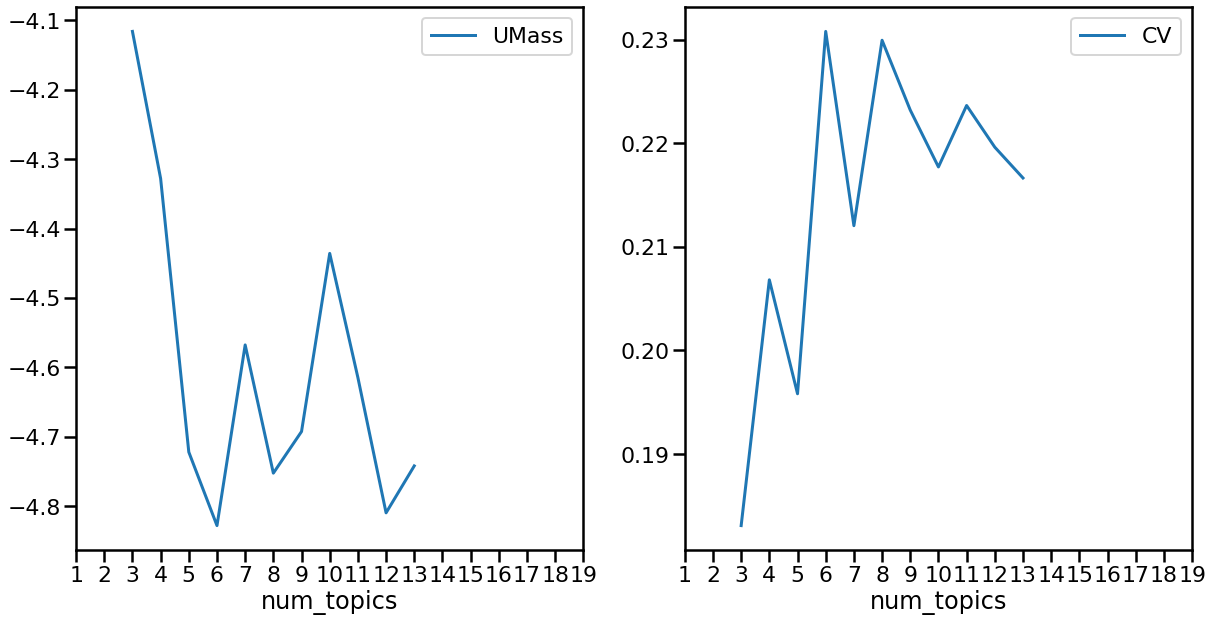

In [44]:
'''
Plot for UMass and CV score
'''

%matplotlib inline
sb.set_context('poster')

scores = pd.DataFrame(coherence_values_0, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1,20));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1,20));

In [45]:
'''
Basing on the UMass score and the CV score, we decide  to maximize the CV score, by picking a number of topics = 6.
'''

num_topics = 6

num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, 
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=42
                    )
    
print("done in {}".format(time.time()-start), flush=True)
print('Perplexity: ', model.log_perplexity(model_corpus))

331.1
fitting model
done in 16.84945034980774
Perplexity:  -5.06496437447225


In [46]:
'''
Here, we print the topics that we get from the topic model.
'''

topic_sep = re.compile("0\.[0-9]{3}\*") 

model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "stasera", "volere", "palco", "vincere", "orietta_berti"
2 "festival_di_sanremo", "stare", "spotify", "quando", "fedez"
3 "canzone", "fiorello", "amadeus", "solere", "cosa"
4 "sempre", "vedere", "altro", "andare", "senza"
5 "cantare", "elodie", "achille_lauro", "anno", "ibrahimovic"
6 "sanremo", "primo", "maneskin", "serata", "potere"


In [47]:
'''
Here, we build a dataframe related to the score of each topic inside each of the document (tweets)
'''

topic_corpus = model[model_corpus]

target_category = 'Region'

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(topic_corpus))]

topic_distros = pd.DataFrame(data=scores, columns=descriptors)

topic_distros['Regioni'] = df_Sanremo[target_category]

In [48]:
topic_distros.head()

,"stasera, volere","festival_di_sanremo, stare","canzone, fiorello","sempre, vedere","cantare, elodie","sanremo, primo",Regioni
0,0.113285,0.113296,0.433565,0.113284,0.113284,0.113285,Lazio
1,0.100616,0.201782,0.218353,0.100380,0.278502,0.100367,Lazio
2,0.102003,0.101081,0.284012,0.216070,0.180339,0.116495,Lazio
3,0.172986,0.284712,0.095956,0.190643,0.095969,0.159735,Lazio
4,0.125002,0.125002,0.125001,0.125001,0.374992,0.125001,Lazio


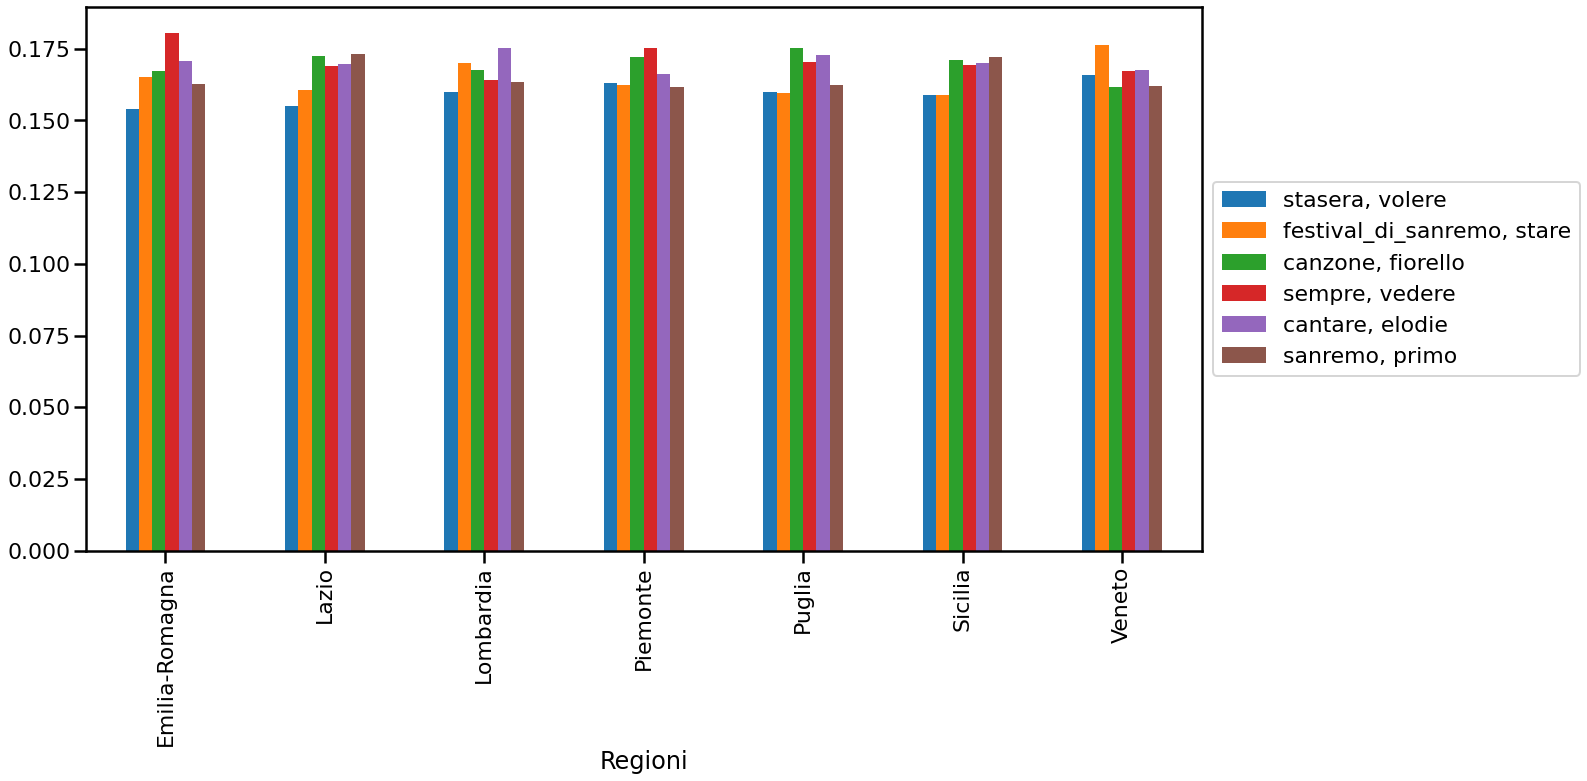

In [49]:
sb.set_context('poster') # use large font
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size

# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.Regioni.isin('Lazio Lombardia Veneto Sicilia Emilia-Romagna Piemonte Puglia'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.Regioni).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [101]:
'''
Results for topic model are not really indicating to a direction: all the topics have a similar percentage across regions,
so there is not a really precise result.
'''

### 7) Author Topic Model

In [51]:
'''
Here, we approach to the topic model in a different way: rather than group by after having built the model, we group by
regions DURING the construction of the model, in order to have more reliable and clearer results
'''

author2doc = defaultdict(list) # mapping from country to document

for i, region in enumerate(df_Sanremo[target_category]):
    author2doc[region].append(i)

coherence_values_1 = []
author_model_list = []

dev_author2doc = {key: [idx for idx in value] for key, value in author2doc.items()}

for num_topics in range(3, 18):
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=42
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values_1.append((num_topics, umass_score, cv_score))

3 -4.164477755224314 0.20126914261011053
4 -4.138086414551585 0.21916498221697692
5 -4.743482998405609 0.23498893309023533
6 -4.737699791306622 0.2446810031997908
7 -4.6334318707741176 0.24128428922745068
8 -4.873875875935807 0.24382988145975312
9 -5.0868683740405745 0.24544658497718785
10 -5.097240497896461 0.24832401386603192
11 -5.033389564871927 0.25457640906180407
12 -4.676263572804598 0.24204188605890364
13 -4.873000031701737 0.2434766182769696
14 -4.907878779808592 0.24311304038712683
15 -4.9330855785803225 0.24724338810314658
16 -4.92237535388229 0.24491973676830475
17 -4.876562753473606 0.24133441376917802


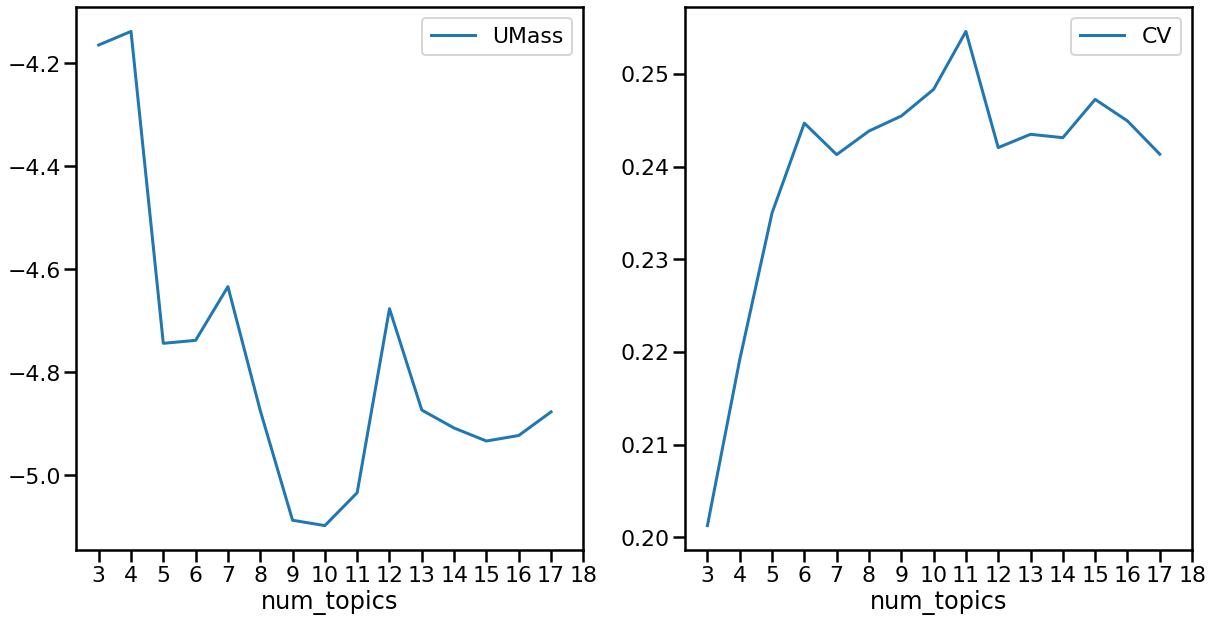

In [52]:
'''
Plot for UMass and CV score
'''

%matplotlib inline
scores = pd.DataFrame(coherence_values_1, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,19));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,19));

In [53]:
'''
Here, we look for a value that do not maximize one or minimize the other, but we look for a medium value between both UMass 
score and CV score. Best Value seems to be 7.
'''
n_topics_author = 7

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=42
)

In [54]:
'''
List of topics found thanks to Author topic model
'''
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "ospite", "volere", "stasera", "vedere", "elodie"
2 "festival_di_sanremo", "stare", "serata", "musico", "spotify"
3 "dovere", "potere", "comunque", "guardare", "senza"
4 "cantare", "palco", "anno", "sempre", "altro"
5 "canzone", "primo", "solere", "dire", "irama"
6 "sanremo", "ariston", "maneskin", "dopo", "marzo"
7 "festival", "amadeus", "fiorello", "ibrahimovic", "parlare"


In [100]:
'''
We can immediately see that the topics found with the author topic model are not that different from the ones found in 
the topic model. Among the unique words that appear just a couple of them seems to be important or indicates something
that could be interesting (elodie, irama, ariston, festival).
'''

In [56]:
'''
Score for each of the topics for every region
'''
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_countries = [i for i in list(set(df_Sanremo['Region']))]
for country in target_countries:
    print(country, author_vecs[country])   

Lazio {'ospite, volere': 0.16456662768806263, 'festival_di_sanremo, stare': 0.10361806568243102, 'dovere, potere': 0.024239555884901173, 'cantare, palco': 0.1640747831131593, 'canzone, primo': 0.1014673228845705, 'sanremo, ariston': 0.3315384509450405, 'festival, amadeus': 0.11049519380183499}
Piemonte {'ospite, volere': 0.11757076474084116, 'festival_di_sanremo, stare': 0.1534411105396175, 'dovere, potere': 0.2177122381215335, 'cantare, palco': 0.1031241645223077, 'canzone, primo': 0.16939941792035138, 'sanremo, ariston': 0.1795838392899872, 'festival, amadeus': 0.05916846486536164}
Puglia {'ospite, volere': 0.09048439874827471, 'festival_di_sanremo, stare': 0.0423545742306104, 'dovere, potere': 0.16560683272232482, 'cantare, palco': 0.19211107289456658, 'canzone, primo': 0.1873528652748606, 'sanremo, ariston': 0.20314266606286782, 'festival, amadeus': 0.11894759006649512}
Lombardia {'ospite, volere': 0.2949123455006251, 'festival_di_sanremo, stare': 0.12932769316070955, 'dovere, pote

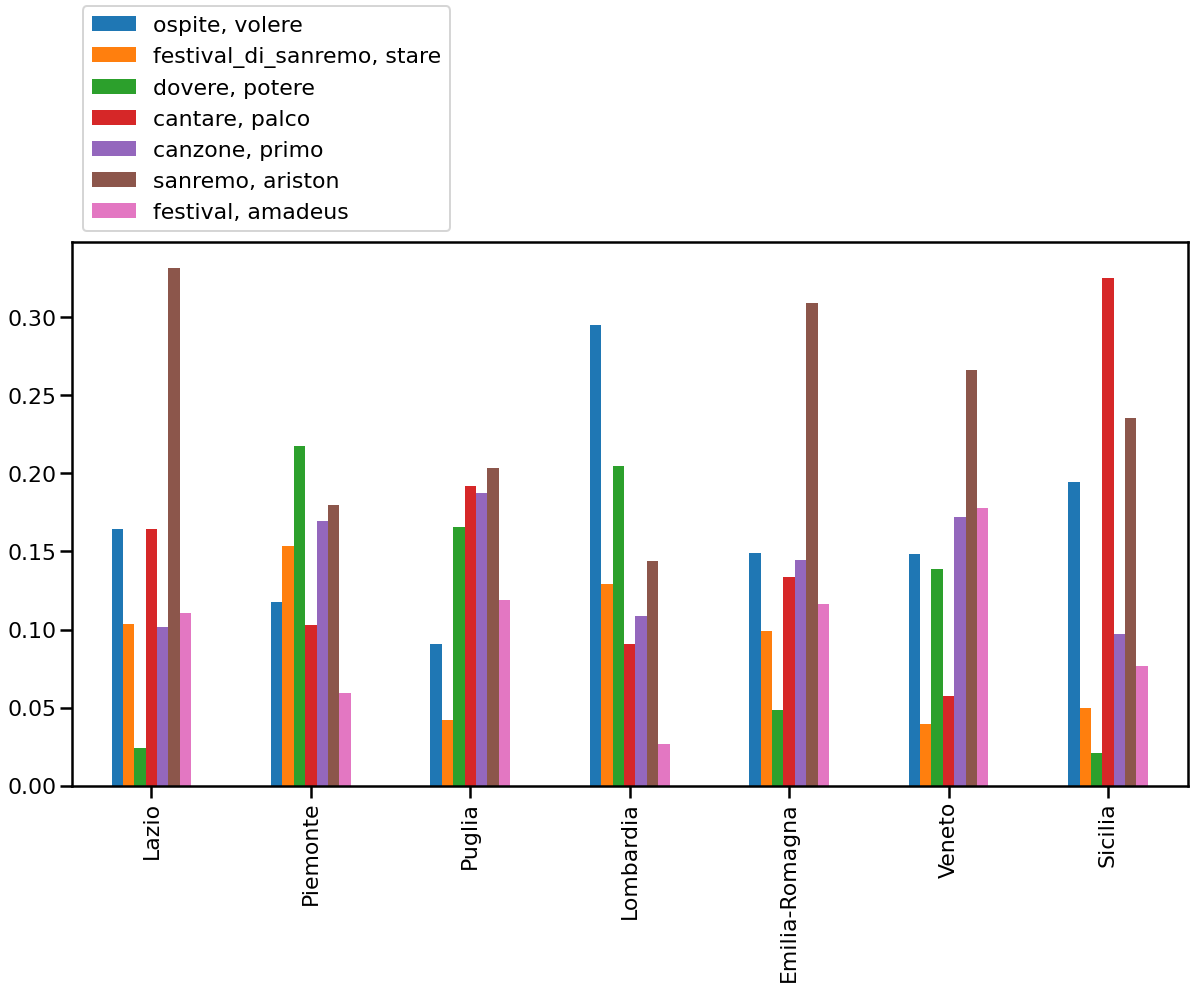

In [57]:
# make a DataFrame
author_df = pd.DataFrame.from_dict(author_vecs)

# plot it
fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax)
plt.legend(loc='lower left', bbox_to_anchor=(0, 1));

In [99]:
'''
Here we have a better plot: it's interesting that across Emilia, Veneto and Lazio 'sanremo,ariston' is the dominant topic with 
respect to the others. Moreover, we can immediately see that there is a greater difference between topic distributions 
with respect to topic model.
'''

### 8) Matrix Factorization

In [59]:
'''
SVD decomposes the data into three components: the document view U, the singular values S, and the term view V. We can use the
term views V to describe the latent concept dimensions. What we basically do is to see if the topics that we're extracting
from the text via term view V are similar to the ones we got from the topic model and from region topic model. The aim of 
Matrix Factorization is again to understand which are the 'topics' of the corpus. Here, as before, we decide to put a max_df
of 0.95.
'''

text = [i for i in df_Sanremo['tweet']]

tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.95, 
                                   ngram_range=(1,2),
                                   stop_words=None, 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(text)

k = 10

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

Wall time: 125 ms


In [60]:
'''
Here, we find the top N words for each of the latent dimensions (=rows) in a matrix
'''

def show_topics(A, vocabulary, topn=5):
    
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [61]:
'''
These are the topics found thanks to matrix factorization
'''

terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['festival_di_sanremo, maneskin, sanremo, festival, fiorello',
 'maneskin, maneskin maneskin, zittiebuoni, maneskin zittiebuoni, maneskinfanclub',
 'festival_di_sanremo, festival_di_sanremo festival_di_sanremo, festival, festival_di_sanremo festival, sanremo',
 'fiorello, festival_di_sanremo, amadeus, festival_di_sanremo festival_di_sanremo, amadeus fiorello',
 'elodie, dopo, spotify, amore, bellezza',
 'sanremo, festival, serata, amadeus, festival sanremo',
 'sanremo, anno, bugo, quest, quest anno',
 'anno, festival, quest, quest anno, amadeus',
 'ibrahimovic, amadeus, volere, ibra, orietta',
 'achille_lauro, stasera, palco, ariston, volere']

In [98]:
'''
As we can see, topics found thanks to matrix factorization are not that different from the ones found with Topic Model and
Author Topic Model.
'''

In [63]:
'''
Function to plot the input in 2 or 3 dimensions. 
'''
import seaborn as sb
sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    fig = plt.figure(figsize=(10,10))

    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('spring') 
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    if dimensions == 3:
        df['z'] = vectors[:,2]

        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 

        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

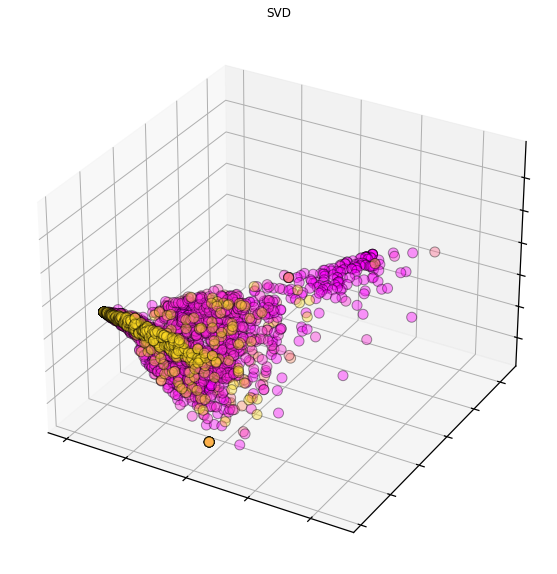

In [64]:
import seaborn as sb
from matplotlib import colors
import matplotlib.pyplot as plt

low_dim_svd = TruncatedSVD(n_components=3)

Z = X
categories = df_Sanremo['Region']

low_dim_U = low_dim_svd.fit_transform(Z)

plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=3)

In [97]:
'''
From the graph for matrix factorization it doesn't appear to be a clear distinction between the topics generated by the code
'''

### 9) Clustering

In [66]:
'''
Here, we try firstly to see if there is any important cluster in our refined tweets list. This could be important in order
to understand if there is some specific topic which was particularly discussed by people. Thiss will be done by finding
the optimal number of clusters inside our dataframe, thanks to silouhette score. Moreover, we'll try to analyze the clusters
we get, in order to understand if there is any important difference or if a cluster is predominant with respect to the others.
'''

k = 16 #starting value

%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

Wall time: 1.77 s


In [67]:
sample = np.random.choice(len(X2), replace=False, size=5000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

Wall time: 9.96 s


In [68]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(16, 300)


In [69]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

%time km.fit(X2)

Wall time: 195 ms


KMeans(init=array([[ 0.08329034, -0.01994225, -0.01682497, ...,  0.00122361,
         0.00014967,  0.0001954 ],
       [ 0.08888268, -0.00765319, -0.00056333, ..., -0.00272687,
         0.00125703, -0.00180358],
       [ 0.08735756, -0.03328936, -0.04029315, ...,  0.00096397,
         0.00442425,  0.00269423],
       ...,
       [ 0.11232201, -0.05337421,  0.00160149, ...,  0.00476388,
        -0.00439336, -0.00172735],
       [ 0.04932499, -0.01723341, -0.00754935, ..., -0.00350173,
        -0.00313597,  0.00100014],
       [ 0.15494554, -0.05908082, -0.04743751, ..., -0.00073049,
         0.00332934, -0.00158599]]),
       n_clusters=16, n_jobs=-1)

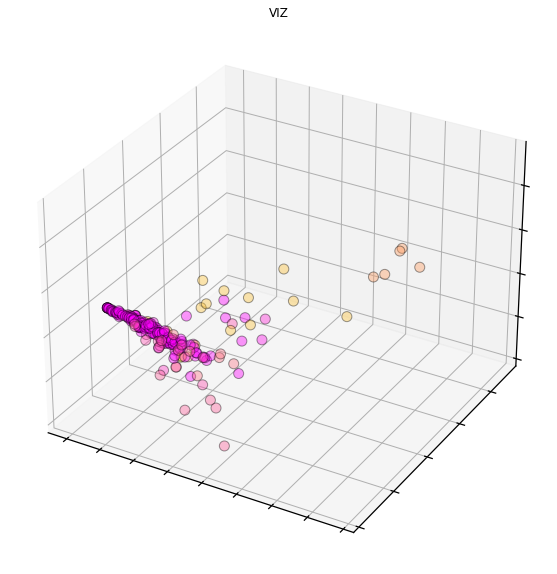

In [70]:
'''
Plot for K = 16, 3-dimensions.
'''

plot_sample = np.random.choice(len(X2), replace=False, size=200)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

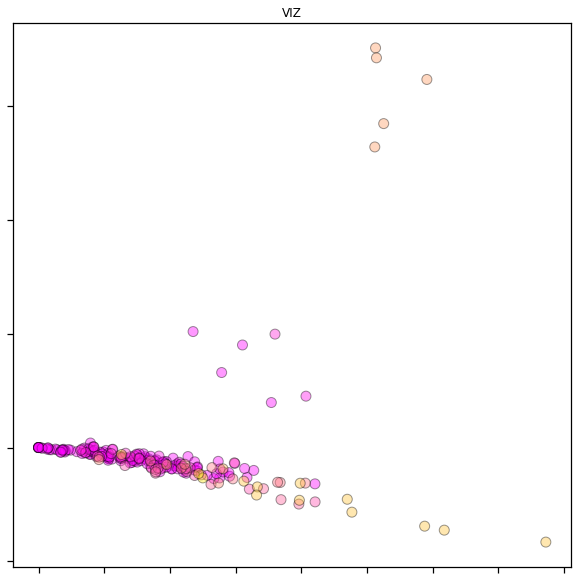

In [71]:

'''
Plot for K = 16, 2-dimensions.
'''
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

2 0.07757909443517626
3 0.02138223993449888
4 0.02254453189417439
5 0.020476326726714494
6 0.022305797159794236
7 0.022292347991356036
8 0.022476946061502048
9 0.02047659315460355
10 0.02315788633864958
11 0.024051067154949448
12 0.023903669565658366
13 0.024476731724799305
14 0.026065588356787326
15 0.026516398294108574
16 0.027346263776287343
17 0.028737529763217685
18 0.029173110559508608
19 0.029949595459463352


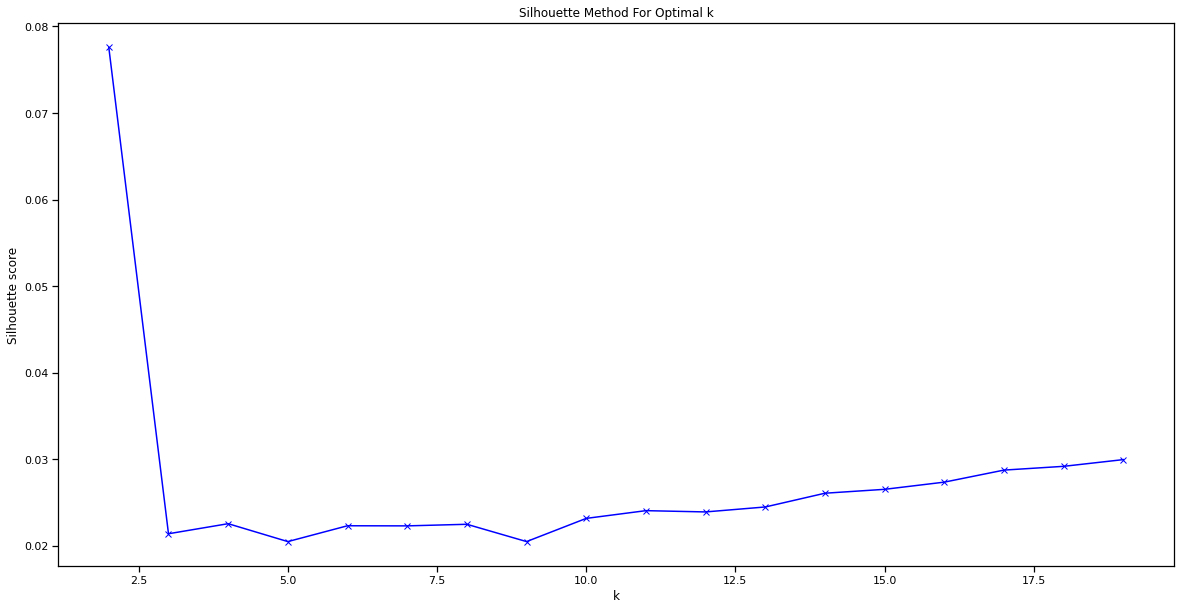

In [72]:
'''
Here, we compute the silouhette score, in order to understand the optimal number of cluster given the text that we have.
'''

silhouettes = []

K = range(2, 20)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [73]:
k = 5 

'''
we try to put 5 clusters, in order to understand if it is possible to get a good number of clusters, even if the silhouette
score is not that high for that specific value.
'''

agg = AgglomerativeClustering(n_clusters=k)
%time agg_sample_ids = agg.fit_predict(X2[sample])
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

Wall time: 9.91 s
(5, 300)


In [74]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

%time km.fit(X2)

Wall time: 103 ms


KMeans(init=array([[ 0.08469101, -0.02022214, -0.01575868, ...,  0.00122664,
         0.00028776,  0.00003617],
       [ 0.24574918,  0.59060979,  0.01228116, ..., -0.0004876 ,
         0.00036834,  0.00062099],
       [ 0.24912753, -0.09730014,  0.35538336, ...,  0.00338789,
        -0.00237555,  0.0065348 ],
       [ 0.15494554, -0.05908082, -0.04743751, ..., -0.00073049,
         0.00332934, -0.00158599],
       [ 0.17726355, -0.07803235, -0.2367708 , ..., -0.00446898,
        -0.0024476 , -0.00109593]]),
       n_clusters=5, n_jobs=-1)

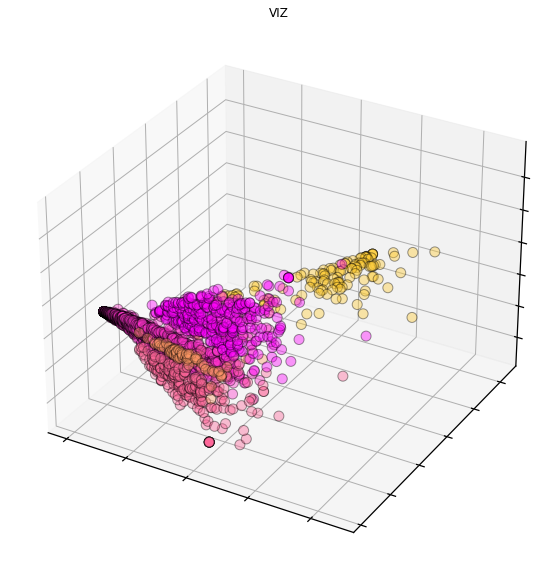

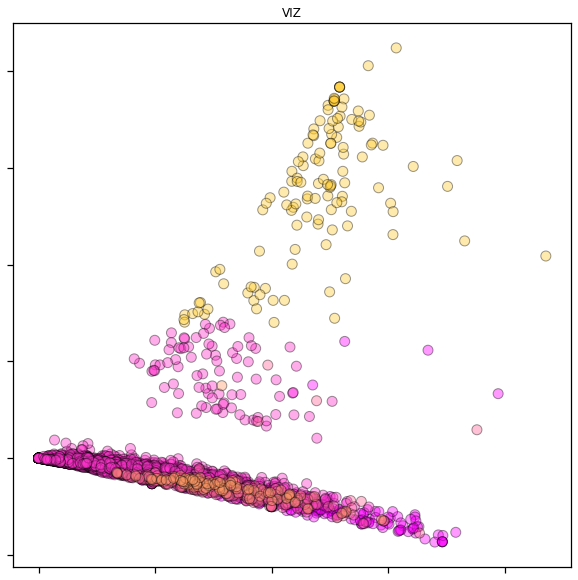

In [75]:
'''
Plot for K = 5, 3-dimensions and 2-dimensions.
'''

plot_sample = np.random.choice(len(X2), replace=False, size= 5000)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=3)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

In [96]:
'''
As we can see even in the clustering, we're not able to appreciate a particular difference between clusters. The topic on the 
bottom keeps the most of the points, so this is meaning that there are not really clusters inside the corpus, but most of the 
people recognise in the predominant cluster, the number 0.
'''

In [77]:
'''
Let's analyse our clusters, in order to understand if we can grasp some more information to understand clustering results.
Basically, here we want to do the same thing that we did before with tags, but with hashtags. We will have a dataframe where
the tweets with more than one hashtags appear the same time as the numbers of hashtags contained, so that every single hashtag
is connected to the text.
'''
df_Sanremo['cluster'] = km.labels_.tolist() #We label every tweet with its dominant cluster

a = list(df_Sanremo['hashtags'])
g = [a[i].replace(',', ' ') for i in range(len(a))]
    
tokens1 = [[word.text for word in nlp(tag)]
          for tag in g]

d = [len(tokens1[i]) for i in range(len(tokens1))]
    
e = [[i, d[i]] for i in range(len(d)) if d[i] > 1]

f = []

for i in range(len(e)):
    f.append(pd.concat([df_Sanremo.iloc[(e[i][0]):(e[i][0]+1),:]]*((e[i][1])-1)))
    
f = pd.concat(f)
a = pd.DataFrame(f)

nuovo_dataframe_sanremo = pd.concat([df_Sanremo,a],axis=0)
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.sort_values(by = ['Region','id'],ascending = True)
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.reset_index()
nuovo_dataframe_sanremo = nuovo_dataframe_sanremo.drop(['index'],axis=1)

A = list(nuovo_dataframe_sanremo['hashtags'])
G = [A[i].replace(',', ' ').lower() for i in range(len(A))]
    
tokens2 = [[word.text for word in nlp(tag.lower())]
          for tag in G]

n_d_f = nuovo_dataframe_sanremo

n_d_f['num'] = pd.Series(tokens2)
n_d_f['count'] = n_d_f.groupby('id').cumcount()

n_d_f['hashtags'] = n_d_f.apply(lambda x: x['num'][x['count']] if len(x['num'])>0 else '', axis=1)

n_d_f = n_d_f.drop(['num','count'],axis=1)

data_cluster = n_d_f.groupby(['cluster','hashtags']).aggregate({'hashtags':'count'})
data_cluster.columns = ['num']
data_cluster = data_cluster.reset_index()
data_cluster = data_cluster.groupby(['cluster']).aggregate({'hashtags':'first','num':'max'})

In [78]:
'''
With this function, we return the word with the highest tfidf value given the list that we pass.
'''

def funzionetfidf(lista):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   ngram_range=(1,2),
                                   stop_words=None, 
                                   sublinear_tf=True)
    X = tfidf_vectorizer.fit_transform(lista)
    vectorizer = CountVectorizer(analyzer='word', 
                             min_df=0.001, 
                             max_df=0.75,
                             ngram_range=(1,2),
                             stop_words=None)
    X2 = vectorizer.fit_transform(lista)
    df_Confronto = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf'], ascending = False)
    df_Confronto = df_Confronto.reset_index()
    df_Confronto = df_Confronto.drop(['index'],axis=1)
    return df_Confronto.iloc[0,0], df_Confronto.iloc[0,3]

In [79]:
'''
We take tweets text related to each single cluster.
'''

cluster_0 = [i for i in df_Sanremo[df_Sanremo['cluster'] == 0]['tweet']]
cluster_1 = [i for i in df_Sanremo[df_Sanremo['cluster'] == 1]['tweet']]
cluster_2 = [i for i in df_Sanremo[df_Sanremo['cluster'] == 2]['tweet']]
cluster_3 = [i for i in df_Sanremo[df_Sanremo['cluster'] == 3]['tweet']]
cluster_4 = [i for i in df_Sanremo[df_Sanremo['cluster'] == 4]['tweet']]

In [80]:
'''
We apply the tfidf function to the list we just created.
'''

data_cluster['highest_tfidf'] = [funzionetfidf(cluster_0)[0],funzionetfidf(cluster_1)[0],funzionetfidf(cluster_2)[0],funzionetfidf(cluster_3)[0],funzionetfidf(cluster_4)[0]]
data_cluster['value_tfidf'] = [funzionetfidf(cluster_0)[1],funzionetfidf(cluster_1)[1],funzionetfidf(cluster_2)[1],funzionetfidf(cluster_3)[1],funzionetfidf(cluster_4)[1]]

In [81]:
'''
Here we want to groupby by region and cluster, in orther to get the percentage of tweets inside the region that are dominated
by the cluster. With this approach, we understand which is the dominant cluster inside each of the region, and with which 
percentage it is dominating.
'''

Dominant_cluster = df_Sanremo.groupby(['Region','cluster']).aggregate({'cluster':'count'})
Dominant_cluster.columns = ['count']
Dominant_cluster = Dominant_cluster.reset_index()
Dominant_cluster = Dominant_cluster.groupby(['Region']).aggregate({'cluster':'first','count':'max'})
Dominant_cluster = Dominant_cluster.reset_index()
percentages = []
for i in range(len(Dominant_cluster)):
    percentages.append(f"{round((Dominant_cluster['count'][i]/len(df_Sanremo[df_Sanremo['Region'] == Dominant_cluster['Region'][i]]))*100,3)}%")
Dominant_cluster['percentages'] = percentages
Dominant_cluster = Dominant_cluster.sort_values(by=['percentages'],ascending=False)
Dominant_cluster = Dominant_cluster.reset_index()
Dominant_cluster = Dominant_cluster.drop(['index'],axis=1)

In [82]:
Dominant_cluster

,Region,cluster,count,percentages
0,Puglia,0,346,91.777%
1,Piemonte,0,365,90.347%
2,Veneto,0,295,90.214%
3,Sicilia,0,523,88.644%
4,Emilia-Romagna,0,390,87.248%
5,Lombardia,0,1668,86.559%
6,Lazio,0,2120,83.137%


In [83]:
data_cluster

,hashtags,num,highest_tfidf,value_tfidf
cluster,,,,
0,105raccontasanremo,5730,sanremo,101.069928
1,105raccontasanremo,167,zittiebuoni,9.698736
2,1marzo,366,festival_di_sanremo festival_di_sanremo,11.834165
3,2marzo,100,anche,2.259839
4,105raccontasanremo,290,amadeus,10.496903


In [95]:
'''
From these two dataframes, we have pretty interesting results: we can immediately see from 'Dominant_cluster' dataframe
that the dominant topic inside each region is always the same, and it is keeping nearly 90% of tweets in each region. This
indicates that the cluster 0 is taking the most of our tweets. Going to the 'data_cluster' dataframe, we can see that the most 
frequent hashtag is the '105raccontasanremo', and the word with the highest tfidf_value is sanremo. Probably this is indicating
that our dataset is not good for clustering: people tend to talk mostly about sanremo and not about related topic. Also from the
fact that sanremo has a tfidf value of 101, while the second word with the highest tfidf value has a value of 12 indicates that
probably cluster 0 is really dominant with respect to the others.
'''

### 10) Sentiment Analysis

In [85]:
'''
Here we try to understand if the sentiment of the people across different regions related to each of the competitor
matches the final ranking. We'll try to rebuild the ranking basing on the sentiment analysis, computing also the mean squared
error between real data and predicted ones.
'''

'Refining english text'
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

'Removing links'
df_Sanremo.tweet_tradotto = [re.sub(re.compile('https?://[\w/%-.]*'),'',tweet) for tweet in df_Sanremo.tweet_tradotto]

'Removing punctuation'
df_Sanremo.tweet_tradotto = [re.sub(re.compile("[’”“«♀,./\➡|♂""•;@»#-?!&º—$']+"), ' ', tweet) for tweet in df_Sanremo.tweet_tradotto]

'Tokenization and removing stopwords'
def cleaning(testo):
    return ' '.join([token.text for token in nlp(testo.lower()) 
              if token.text not in stop_words])
    
df_Sanremo.tweet_tradotto = df_Sanremo.tweet_tradotto.apply(lambda x: cleaning(x))

'Stripping'
df_Sanremo.tweet_tradotto = df_Sanremo.tweet_tradotto.apply(lambda x: x.strip())

'Remvoing excessive spaces'
df_Sanremo.tweet_tradotto = [re.sub('\s\s+', ' ', tweet) for tweet in  df_Sanremo.tweet_tradotto]

In [86]:
'''
Let's estrapolate the tweets containing the names of each of the competitor.
'''

Names = ['maneskin','fedez','ermal meta','colapesce','irama','peyote','annalisa','madame', 'orietta berti', 'arisa'\
        , 'rappresentantedilista', 'extraliscio','lo stato sociale','noemi','malika','fulminacci','max gazzè','fasma'\
        ,'gaia','coma_cose','ghemon','renga','gio evan','bugo','aiello','random']
True_ranking = [i for i in range(1,27)]

lista_tweet = []
for i in range(len(Names)):
    lista_tweet.append([j for j in df_Sanremo[df_Sanremo['tweet_tradotto'].str.contains(Names[i])]['tweet_tradotto']])

In [87]:
'''
Average compound value for each Sanremo competitor. We use again the function meanofatext, built in the Language Model section.
'''

for i in range(len(Names)):
    print('Mean of compound value for {}: {}'.format(Names[i],meanofatext(lista_tweet[i])))

Mean of compound value for maneskin: 0.19353767605633804
Mean of compound value for fedez: 0.172946835443038
Mean of compound value for ermal meta: 0.3394069767441861
Mean of compound value for colapesce: 0.16883924050632915
Mean of compound value for irama: 0.24937898089171975
Mean of compound value for peyote: 0.22561645569620256
Mean of compound value for annalisa: 0.2530164705882353
Mean of compound value for madame: 0.24210799999999996
Mean of compound value for orietta berti: 0.12114285714285715
Mean of compound value for arisa: 0.18339272727272726
Mean of compound value for rappresentantedilista: 0.365813043478261
Mean of compound value for extraliscio: 0.20386190476190477
Mean of compound value for lo stato sociale: 0.3287
Mean of compound value for noemi: 0.1394763358778626
Mean of compound value for malika: 0.35185681818181813
Mean of compound value for fulminacci: 0.1617869565217391
Mean of compound value for max gazzè: 0.03841875
Mean of compound value for fasma: 0.10364310

In [88]:
compound_values = [meanofatext(lista_tweet[i]) for i in range(len(Names))]

ranking_sentiment = pd.DataFrame(data=[Names,True_ranking,compound_values]).T
ranking_sentiment.columns = ['Artist','True_Ranking','Compound_Val']
ranking_sentiment = ranking_sentiment.sort_values(by=['Compound_Val'], ascending = False)
ranking_sentiment['Presumed_ranking'] = [i for i in range(1,27)]
ranking_sentiment = ranking_sentiment.reset_index()
ranking_sentiment = ranking_sentiment.drop(['index'],axis=1)
ranking_sentiment

,Artist,True_Ranking,Compound_Val,Presumed_ranking
0,rappresentantedilista,11,0.365813,1
1,malika,15,0.351857,2
2,ermal meta,3,0.339407,3
3,lo stato sociale,13,0.3287,4
4,annalisa,7,0.253016,5
5,irama,5,0.249379,6
6,madame,8,0.242108,7
7,peyote,6,0.225616,8
8,coma_cose,20,0.224858,9
9,gaia,19,0.204354,10


In [89]:
'''
Computing the ROOT MEAN SQUARED ERROR.
'''

RMSE = np.sqrt(sum((ranking_sentiment['True_Ranking']-ranking_sentiment['Presumed_ranking'])**2)/len(ranking_sentiment))

print(RMSE)

6.944837595708717


In [94]:
'''
This ROOT MEAN SQUARED ERROR indicates the mean difference from the real ranking of each competitor and the predicted value, 
evaluated thanks to the mean compound value. This difference states that probably people were tweeting positively or negatively
not just about the music performance, but also about dressing, physical aspect... So this great difference probably comes out 
from this.
'''

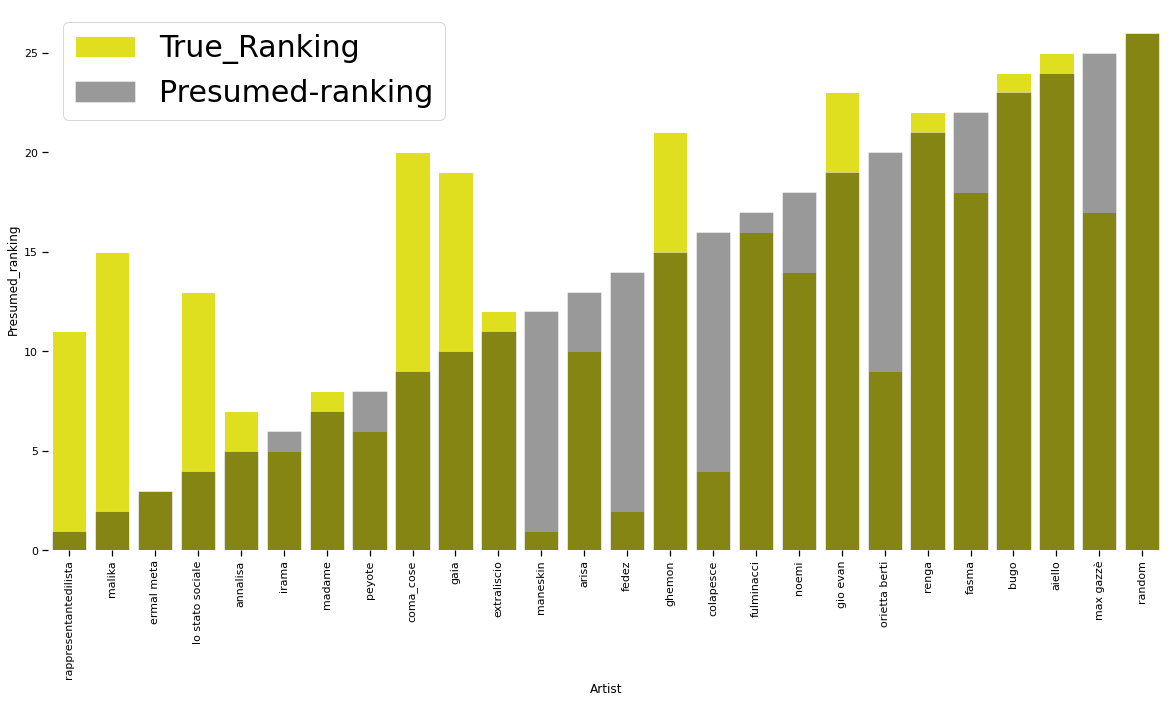

In [91]:
f, ax = plt.subplots(figsize = (20,10))
sb.barplot(x = 'Artist', y = 'True_Ranking', data = ranking_sentiment,
            label = 'True_Ranking', color = 'yellow', edgecolor = 'w')
sb.set_color_codes('muted')
sb.barplot(x = 'Artist', y = 'Presumed_ranking', data = ranking_sentiment,
            label = 'Presumed-ranking', color = 'black', edgecolor = 'w',alpha=0.4)
ax.legend(ncol = 1, loc = 'upper left', fontsize='30')
sb.despine(left = True, bottom = True)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

In [93]:
'''
As we can see from the plot, rappresentantedilista moved from the eleventh to the first position, thanks to the mean compound
value related to his tweet. Interesting is the fact that maneskin, even appearing in a great number of tweets, lost 10 positions
with respect to their starting point. Another interesting thing is that the only two competitors that had the same exact
positioning in real data and in predicted data are Ermal Meta, who was third in real life, and confirmed his position, and 
Random, who was last in real data, and last in predicted data. Probably the audience didn't really appreciate his performances.
'''

### Conclusion

During this project, I understood that Italian people are really involved in discussing about Sanremo. Moreover, it was interesting to realize that they tend to write a lot about presentors (Fiorello, Amadeus, Ibrahimovic), even more than singers. For this reason, and also considering the fact that sentiment analysis revealed that they tweet more favourable or unfavourable tweet about singers independently from the music performance, I can state that in Italy, more than a singing competition, Sanremo is seen from the population as a show, for which people wait the entire year.